In [1]:
%reload_ext autoreload
%autoreload 2

import os
import gc
import pickle
import logging
import multiprocessing
from pathlib import Path

import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import numpyro

from hbmep.config import Config
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
formatter = logging.Formatter(FORMAT)

fhandler = logging.FileHandler(filename='power-analysis-parallel.log', mode="w")
fhandler.setFormatter(formatter)
fhandler.setLevel(logging.INFO)
logger.addHandler(fhandler)

# consoleHandler = logging.StreamHandler(sys.stdout)
# consoleHandler.setFormatter(formatter)
# logger.addHandler(consoleHandler)


In [ ]:
import numpyro.distributions as dist
from hbmep.model import Baseline
from hbmep_paper.utils.constants import HBM


class HierarchicalBayesianModel(Baseline):
    LINK = HBM

    def __init__(self, config: Config):
        super(HierarchicalBayesianModel, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]
        self.priors = {"baseline", "delta", site.a, site.b, site.L, site.H, site.v, site.g_1, site.g_2}

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        n_baseline = 1
        n_delta = n_feature0 - 1

        """ Baseline """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_baseline", n_baseline, dim=-2):
                mu_baseline = numpyro.sample(
                    "mu_baseline",
                    dist.TruncatedNormal(5, 10, low=0)
                )
                sigma_baseline = numpyro.sample(
                    "sigma_baseline",
                    dist.HalfNormal(10.0)
                )

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    baseline = numpyro.sample(
                        "baseline",
                        dist.TruncatedNormal(mu_baseline, sigma_baseline, low=0)
                    )

        """ Delta """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_delta", n_delta, dim=-2):
                mu_delta = numpyro.sample("mu_delta", dist.Normal(0, 10))
                sigma_delta = numpyro.sample("sigma_delta", dist.HalfNormal(10.0))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    delta = numpyro.sample("delta", dist.Normal(mu_delta, sigma_delta))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                """ Hyper-priors """
                sigma_b = numpyro.sample(site.sigma_b, dist.HalfNormal(10))

                sigma_L = numpyro.sample(site.sigma_L, dist.HalfNormal(2))
                sigma_H = numpyro.sample(site.sigma_H, dist.HalfNormal(10))
                sigma_v = numpyro.sample(site.sigma_v, dist.HalfNormal(10))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([baseline, baseline + delta], axis=1)
                    )
                    b = numpyro.sample(site.b, dist.HalfNormal(sigma_b))

                    L = numpyro.sample(site.L, dist.HalfNormal(sigma_L))
                    H = numpyro.sample(site.H, dist.HalfNormal(sigma_H))
                    v = numpyro.sample(site.v, dist.HalfNormal(sigma_v))

                    g_1 = numpyro.sample(site.g_1, dist.Exponential(0.01))
                    g_2 = numpyro.sample(site.g_2, dist.Exponential(0.01))

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[subject, feature0]
            + jnp.maximum(
                0,
                -1
                + (H[subject, feature0] + 1)
                / jnp.power(
                    1
                    + (jnp.power(1 + H[subject, feature0], v[subject, feature0]) - 1)
                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0])),
                    1 / v[subject, feature0]
                )
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[subject, feature0] + g_2[subject, feature0] * (1 / mu) ** 2
        )

        """ Penalty """
        penalty = (jnp.fabs(baseline + delta) - (baseline + delta))
        numpyro.factor("penalty", -penalty)

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )


In [1]:
%reload_ext autoreload
%autoreload 2

import os
import gc
import pickle
import logging
import multiprocessing
from pathlib import Path

import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import numpyro

from hbmep.config import Config
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
formatter = logging.Formatter(FORMAT)

fhandler = logging.FileHandler(filename='power-analysis-parallel.log', mode="w")
fhandler.setFormatter(formatter)
fhandler.setLevel(logging.INFO)
logger.addHandler(fhandler)

# consoleHandler = logging.StreamHandler(sys.stdout)
# consoleHandler.setFormatter(formatter)
# logger.addHandler(consoleHandler)


2023-09-28 13:41:27,444 - root - INFO - 

****This is HBMEP****




In [2]:
import gc
from collections import Counter

import jax;
jax.config.update('jax_platform_name', 'cpu')
from jax import numpy as np
from jax import lax, random

class ABC:
    def body_fn(self, i, key):
        key, _ = random.split(key)
        return key

for i in range(3):
    abc = ABC()
    value = lax.fori_loop(0, 10, abc.body_fn, random.PRNGKey(0))

    print("\nGC OBJECTS:")
    cnt = Counter()
    # force collection; it is expected that count of different types
    # should not increase per iteration
    gc.collect()
    for x in gc.get_objects():
        if isinstance(x, list):
            if len(x) > 1:
                cnt[type(x[0])] += 1
    print(cnt.most_common(10))


GC OBJECTS:
[(<class 'float'>, 3940), (<class 'str'>, 2620), (<class 'tuple'>, 1408), (<class 'method'>, 215), (<class 'traitlets.traitlets.ObserveHandler'>, 209), (<class 'int'>, 105), (<class 'bool'>, 72), (<class 'list'>, 68), (<class 'jax._src.core.Var'>, 65), (<class 'fontTools.ttLib.tables.otConverters.ComputedUShort'>, 54)]

GC OBJECTS:
[(<class 'float'>, 3940), (<class 'str'>, 2619), (<class 'tuple'>, 1409), (<class 'method'>, 215), (<class 'traitlets.traitlets.ObserveHandler'>, 209), (<class 'int'>, 105), (<class 'bool'>, 73), (<class 'jax._src.core.Var'>, 70), (<class 'list'>, 68), (<class 'fontTools.ttLib.tables.otConverters.ComputedUShort'>, 54)]

GC OBJECTS:
[(<class 'float'>, 3940), (<class 'str'>, 2618), (<class 'tuple'>, 1410), (<class 'method'>, 215), (<class 'traitlets.traitlets.ObserveHandler'>, 209), (<class 'int'>, 105), (<class 'jax._src.core.Var'>, 75), (<class 'bool'>, 74), (<class 'list'>, 68), (<class 'fontTools.ttLib.tables.otConverters.ComputedUShort'>, 54)

In [2]:
import numpyro.distributions as dist
from hbmep.model import Baseline
from hbmep_paper.utils.constants import HBM


class HierarchicalBayesianModel(Baseline):
    LINK = HBM

    def __init__(self, config: Config):
        super(HierarchicalBayesianModel, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]
        self.priors = {"baseline", "delta", site.a, site.b, site.L, site.H, site.v, site.g_1, site.g_2}

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        n_baseline = 1
        n_delta = n_feature0 - 1

        """ Baseline """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_baseline", n_baseline, dim=-2):
                mu_baseline = numpyro.sample(
                    "mu_baseline",
                    dist.TruncatedNormal(5, 10, low=0)
                )
                sigma_baseline = numpyro.sample(
                    "sigma_baseline",
                    dist.HalfNormal(10.0)
                )

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    baseline = numpyro.sample(
                        "baseline",
                        dist.TruncatedNormal(mu_baseline, sigma_baseline, low=0)
                    )

        """ Delta """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_delta", n_delta, dim=-2):
                mu_delta = numpyro.sample("mu_delta", dist.Normal(0, 10))
                sigma_delta = numpyro.sample("sigma_delta", dist.HalfNormal(10.0))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    delta = numpyro.sample("delta", dist.Normal(mu_delta, sigma_delta))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                """ Hyper-priors """
                sigma_b = numpyro.sample(site.sigma_b, dist.HalfNormal(10))

                sigma_L = numpyro.sample(site.sigma_L, dist.HalfNormal(2))
                sigma_H = numpyro.sample(site.sigma_H, dist.HalfNormal(10))
                sigma_v = numpyro.sample(site.sigma_v, dist.HalfNormal(10))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([baseline, baseline + delta], axis=1)
                    )
                    b = numpyro.sample(site.b, dist.HalfNormal(sigma_b))

                    L = numpyro.sample(site.L, dist.HalfNormal(sigma_L))
                    H = numpyro.sample(site.H, dist.HalfNormal(sigma_H))
                    v = numpyro.sample(site.v, dist.HalfNormal(sigma_v))

                    g_1 = numpyro.sample(site.g_1, dist.Exponential(0.01))
                    g_2 = numpyro.sample(site.g_2, dist.Exponential(0.01))

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[subject, feature0]
            + jnp.maximum(
                0,
                -1
                + (H[subject, feature0] + 1)
                / jnp.power(
                    1
                    + (jnp.power(1 + H[subject, feature0], v[subject, feature0]) - 1)
                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0])),
                    1 / v[subject, feature0]
                )
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[subject, feature0] + g_2[subject, feature0] * (1 / mu) ** 2
        )

        """ Penalty """
        penalty = (jnp.fabs(baseline + delta) - (baseline + delta))
        numpyro.factor("penalty", -penalty)

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )


In [3]:
import pickle


root_path = Path(os.getcwd()).parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/human/intraoperative/config.toml")

CONFIG = Config(toml_path=toml_path)
MODEL = HierarchicalBayesianModel(config=CONFIG)

src = "/home/vishu/data/hbmep-processed/human/intraoperative/data.csv"
DF = pd.read_csv(src)

subset = [
    'scapptio001'
]
ind = ~DF[MODEL.subject].isin(subset)
DF = DF[ind].reset_index(drop=True).copy()

DF, ENCODER_DICT = MODEL.load(df=DF)

dest = os.path.join(MODEL.build_dir, "inference.pkl")
with open(dest, "rb") as g:
    _, MCMC, POSTERIOR_SAMPLES = pickle.load(g)


2023-09-28 12:53:19,699 - hbmep.config - INFO - Verifying configuration ...
2023-09-28 12:53:19,699 - hbmep.config - INFO - Success!
2023-09-28 12:53:19,704 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-09-28 12:53:19,704 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-09-28 12:53:19,704 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-09-28 12:53:19,705 - jax._src.xla_bridge - WARNING - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2023-09-28 12:53:19,715 - hbmep.model.baseline - INFO - Initialized model with hierarchical_bayesian link
2023-09-28 12:53:19,731 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/human/intraoperative
2023-0

In [4]:
TOTAL_SUBJECTS = 200

PREDICTION_DF = \
    pd.DataFrame(np.arange(0, TOTAL_SUBJECTS, 1), columns=[MODEL.subject]) \
    .merge(
        pd.DataFrame(np.arange(0, 2, 1), columns=MODEL.features),
        how="cross"
    ) \
    .merge(
        pd.DataFrame([0, 10], columns=[MODEL.intensity]),
        how="cross"
    )

PREDICTION_DF = MODEL.make_prediction_dataset(df=PREDICTION_DF, num_points=20)
PREDICTION_DF.shape

2023-09-28 12:53:20,006 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec


(8000, 3)

In [5]:
POST = {u: v for u, v in POSTERIOR_SAMPLES.items() if u not in MODEL.priors}
POSTERIOR_PREDICTIVE = MODEL.predict(df=PREDICTION_DF, posterior_samples=POST)

OBS = np.array(POSTERIOR_PREDICTIVE[site.obs])
OBS.shape

2023-09-28 12:53:32,608 - hbmep.utils.utils - INFO - func:predict took: 12.48 sec


(4000, 8000, 1)

In [6]:
mu_delta_true = POSTERIOR_SAMPLES["mu_delta"]
mu_delta_true.shape

(4000, 1, 1)

In [7]:
prefix = "power-analysis-parallel"

N_space = [2, 4, 8, 12, 16, 20]

n_draws = 50
draws_space = \
    jax.random.choice(
        key=MODEL.rng_key,
        a=np.arange(0, mu_delta_true.shape[0], 1),
        shape=(n_draws,),
        replace=False
    ) \
    .tolist()

n_repeats = 100
repeats_space = \
    jax.random.choice(
        key=MODEL.rng_key,
        a=np.arange(0, 100 * n_repeats, 1),
        shape=(n_repeats,),
        replace=False
    )

# """ Test """
# N_space = [2, 3, 4]

# n_draws = 4
# draws_space = \
#     jax.random.choice(
#         key=MODEL.rng_key,
#         a=np.arange(0, mu_delta_true.shape[0], 1),
#         shape=(n_draws,),
#         replace=False
#     ) \
#     .tolist()

# n_repeats = 2
# repeats_space = \
#     jax.random.choice(
#         key=MODEL.rng_key,
#         a=np.arange(0, 100 * n_repeats, 1),
#         shape=(n_repeats,),
#         replace=False
#     )



In [8]:
def _process(N_counter, draw_counter, repeat_counter):

    # PLATFORM = "cpu"
    # jax.config.update("jax_platforms", PLATFORM)
    # numpyro.set_platform(PLATFORM)

    # cpu_count = multiprocessing.cpu_count() - 2
    # numpyro.set_host_device_count(cpu_count)
    # numpyro.enable_x64()
    # numpyro.enable_validation()

    N = N_space[N_counter]
    draw_ind = draws_space[draw_counter]
    seed = repeats_space[repeat_counter]

    N_dir, draw_dir, seed_dir = f"N_{N}", f"draw_{draw_ind}", f"seed_{seed}"

    subjects_ind = \
        jax.random.choice(
            key=jax.random.PRNGKey(seed),
            a=np.arange(0, TOTAL_SUBJECTS, 1),
            shape=(N,),
            replace=False
        ) \
        .tolist()

    ind = PREDICTION_DF[MODEL.subject].isin(subjects_ind)
    df = PREDICTION_DF[ind].reset_index(drop=True).copy()
    df[MODEL.response] = OBS[draw_ind, ...][ind, ...]

    """ Build model """
    config = Config(toml_path=toml_path)
    config.BUILD_DIR = os.path.join(CONFIG.BUILD_DIR, prefix, draw_dir, N_dir, seed_dir)
    model = HierarchicalBayesianModel(config=config)

    """ Load data """
    df, _ = model.load(df=df)

    """ Fit """
    _, posterior_samples = model.run_inference(df=df)

    """ Predict """
    prediction_df = model.make_prediction_dataset(df=df, num_points=100)
    ppd = model.predict(df=prediction_df, posterior_samples=posterior_samples)

    """ Plot """
    model.render_recruitment_curves(df=df, posterior_samples=posterior_samples, prediction_df=prediction_df, posterior_predictive=ppd)
    model.render_predictive_check(df=df, prediction_df=prediction_df, posterior_predictive=ppd)

    """ Power """
    mu_delta = np.array(posterior_samples["mu_delta"])

    dst = os.path.join(model.build_dir, "mu_delta.npy")
    np.save(dst, mu_delta)
    return
    # config, curr_df, df, encoder_dict,  = None, None, None, None
    # mcmc, model, posterior_samples = None, None, None
    # prediction_df, ppd = None, None
    # mu_delta = None


In [9]:
_process(0, 0, 0)

2023-09-28 12:53:33,851 - hbmep.config - INFO - Verifying configuration ...
2023-09-28 12:53:33,851 - hbmep.config - INFO - Success!
2023-09-28 12:53:33,852 - hbmep.model.baseline - INFO - Initialized model with hierarchical_bayesian link
2023-09-28 12:53:33,852 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis-parallel/draw_2829/N_2/seed_1792
2023-09-28 12:53:33,853 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis-parallel/draw_2829/N_2/seed_1792
2023-09-28 12:53:33,854 - hbmep.dataset.core - INFO - Processing data ...
2023-09-28 12:53:33,855 - hbmep.utils.utils - INFO - func:load took: 0.00 sec
/home/vishu/repos/hbmep/src/hbmep/model/baseline.py:571: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.se

In [2]:
jax.

NameError: name 'jax' is not defined

In [9]:
from joblib import Parallel, delayed

In [10]:
parallel = Parallel(n_jobs=-1)

In [11]:
parallel(delayed(_process)(N_counter, draw_counter, repeat_counter) for N_counter in range(len(N_space)) for draw_counter in range(n_draws) for repeat_counter in range(n_repeats))


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and

KeyboardInterrupt: 

In [8]:
logger.info(f"BUILD_DIR: {os.path.join(MODEL.build_dir, prefix)}")
logger.info(f"N_space: {', '.join(map(str, N_space))}")

logger.info(f"n_draws: {n_draws}")
logger.info(f"draws: {', '.join(map(str, draws_space))}")

logger.info(f"n_repeats: {n_repeats}")
logger.info(f"seeds: {', '.join(map(str, repeats_space))}")

mu_delta_predicted = None

for draw_counter, draw_ind in enumerate(draws_space):
    curr_draw_mu_delta = None

    for N_counter, N in enumerate(N_space):
        N_dir = f"N_{N}"
        curr_N_mu_delta = None

        for repeat_counter, seed in enumerate(repeats_space):
            seed_dir = f"seed_{seed}"
            logger.info(f"\n\nDraw:{draw_counter + 1}/{n_draws}, N:{N_counter + 1}/{len(N_space)}, Repeat:{repeat_counter + 1}/{n_repeats}")

            subjects_ind = \
                jax.random.choice(
                    key=jax.random.PRNGKey(seed),
                    a=np.arange(0, TOTAL_SUBJECTS, 1),
                    shape=(N,),
                    replace=False
                ) \
                .tolist()
            logger.info(f"Seed:{seed}, Subjects: {', '.join(map(str, subjects_ind))}")

            ind = PREDICTION_DF[MODEL.subject].isin(subjects_ind)
            curr_df = PREDICTION_DF[ind].reset_index(drop=True).copy()

            df = curr_df.copy()
            df[MODEL.response] = OBS[draw_ind, ...][ind, ...]

            """ Build model """
            config = Config(toml_path=toml_path)
            config.BUILD_DIR = os.path.join(CONFIG.BUILD_DIR, prefix, draw_dir, N_dir, seed_dir)
            model = HierarchicalBayesianModel(config=config)

            """ Load data """
            df, encoder_dict = model.load(df=df)

            """ Fit """
            logger.info("Fitting ...")
            mcmc, posterior_samples = model.run_inference(df=df)

            """ Predict """
            logger.info("Predicting ...")
            prediction_df = model.make_prediction_dataset(df=df, num_points=100)
            ppd = model.predict(df=prediction_df, posterior_samples=posterior_samples)

            """ Plot """
            logger.info("Plotting recruitment curves ...")
            model.render_recruitment_curves(df=df, posterior_samples=posterior_samples, prediction_df=prediction_df, posterior_predictive=ppd)
            logger.info("Plotting posterior checks ...")
            model.render_predictive_check(df=df, prediction_df=prediction_df, posterior_predictive=ppd)

            """ Power """
            mu_delta = posterior_samples["mu_delta"]
            mu_delta = np.array(mu_delta[None, ...])

            """ Concatenate """
            if curr_N_mu_delta is None:
                curr_N_mu_delta = mu_delta
            else:
                curr_N_mu_delta = np.concatenate([curr_N_mu_delta, mu_delta], axis=0)

            config, curr_df, df, encoder_dict,  = None, None, None, None
            mcmc, model, posterior_samples = None, None, None
            prediction_df, ppd = None, None
            mu_delta = None

            del config, curr_df, df, encoder_dict, mcmc, model, posterior_samples, prediction_df, ppd, mu_delta
            gc.collect()

        """ Concatenate """
        curr_N_mu_delta = curr_N_mu_delta[None, ...]

        if curr_draw_mu_delta is None:
            curr_draw_mu_delta = curr_N_mu_delta
        else:
            curr_draw_mu_delta = np.concatenate([curr_draw_mu_delta, curr_N_mu_delta], axis=0)

    """ Concatenate """
    curr_draw_mu_delta = curr_draw_mu_delta[None, ...]

    if mu_delta_predicted is None:
        mu_delta_predicted = curr_draw_mu_delta
    else:
        mu_delta_predicted = np.concatenate([mu_delta_predicted, curr_draw_mu_delta], axis=0)

    dst = os.path.join(MODEL.build_dir, prefix, f"mu_delta_predicted_Draw_{draw_counter + 1}.npy")
    np.save(dst, mu_delta_predicted)
    logger.info(f"Saved to {dst}")


2023-09-27 17:14:38,662 - __main__ - INFO - BUILD_DIR: /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis
2023-09-27 17:14:38,662 - __main__ - INFO - N_space: 2, 4, 8, 12, 16, 20
2023-09-27 17:14:38,663 - __main__ - INFO - n_draws: 50
2023-09-27 17:14:38,663 - __main__ - INFO - draws: 2829, 807, 3728, 3454, 2756, 3889, 1823, 813, 502, 745, 2901, 1220, 3315, 3616, 773, 3672, 1409, 1055, 3458, 458, 3240, 40, 3200, 1983, 3641, 531, 755, 1349, 3178, 1897, 1787, 2597, 1767, 139, 2864, 2618, 1371, 1850, 1750, 2241, 1843, 1509, 2822, 192, 2402, 1497, 3691, 645, 3923, 2428
2023-09-27 17:14:38,664 - __main__ - INFO - n_repeats: 10
2023-09-27 17:14:38,672 - __main__ - INFO - seeds: 339, 777, 129, 822, 616, 214, 204, 912, 698, 677
2023-09-27 17:14:38,673 - __main__ - INFO - 

Draw:1/50, N:1/6, Repeat:1/10
2023-09-27 17:14:38,747 - __main__ - INFO - Seed:339, Subjects: 67, 138
2023-09-27 17:14:38,748 - hbmep.config - INFO - Verifying configuration ...
2023-09-27 17:14:38,748

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:15:04,001 - hbmep.utils.utils - INFO - func:run_inference took: 25.25 sec
2023-09-27 17:15:04,002 - __main__ - INFO - Predicting ...
2023-09-27 17:15:04,007 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:15:04,946 - hbmep.utils.utils - INFO - func:predict took: 0.94 sec
2023-09-27 17:15:04,946 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:15:04,950 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:15:05,744 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_2/seed_339/recruitment_curves.pdf
2023-09-27 17:15:05,744 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.80 sec
2023-09-27 17:15:05,744 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:15:05,750 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:15:06,661 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:15:20,282 - hbmep.utils.utils - INFO - func:run_inference took: 13.51 sec
2023-09-27 17:15:20,283 - __main__ - INFO - Predicting ...
2023-09-27 17:15:20,287 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:15:21,220 - hbmep.utils.utils - INFO - func:predict took: 0.93 sec
2023-09-27 17:15:21,220 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:15:21,224 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:15:21,996 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_2/seed_777/recruitment_curves.pdf
2023-09-27 17:15:21,997 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.78 sec
2023-09-27 17:15:21,997 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:15:22,001 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:15:22,856 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:15:36,862 - hbmep.utils.utils - INFO - func:run_inference took: 13.91 sec
2023-09-27 17:15:36,863 - __main__ - INFO - Predicting ...
2023-09-27 17:15:36,867 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:15:37,804 - hbmep.utils.utils - INFO - func:predict took: 0.94 sec
2023-09-27 17:15:37,805 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:15:37,808 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:15:38,518 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_2/seed_129/recruitment_curves.pdf
2023-09-27 17:15:38,518 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.71 sec
2023-09-27 17:15:38,518 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:15:38,523 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:15:39,440 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:15:55,639 - hbmep.utils.utils - INFO - func:run_inference took: 16.09 sec
2023-09-27 17:15:55,640 - __main__ - INFO - Predicting ...
2023-09-27 17:15:55,644 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:15:56,571 - hbmep.utils.utils - INFO - func:predict took: 0.93 sec
2023-09-27 17:15:56,572 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:15:56,575 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:15:57,284 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_2/seed_822/recruitment_curves.pdf
2023-09-27 17:15:57,285 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.71 sec
2023-09-27 17:15:57,285 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:15:57,289 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:15:58,243 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:16:08,490 - hbmep.utils.utils - INFO - func:run_inference took: 10.13 sec
2023-09-27 17:16:08,491 - __main__ - INFO - Predicting ...
2023-09-27 17:16:08,495 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:16:09,429 - hbmep.utils.utils - INFO - func:predict took: 0.93 sec
2023-09-27 17:16:09,429 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:16:09,433 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:16:10,165 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_2/seed_616/recruitment_curves.pdf
2023-09-27 17:16:10,165 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.74 sec
2023-09-27 17:16:10,166 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:16:10,170 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:16:11,031 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:16:36,707 - hbmep.utils.utils - INFO - func:run_inference took: 25.54 sec
2023-09-27 17:16:36,707 - __main__ - INFO - Predicting ...
2023-09-27 17:16:36,712 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:16:37,647 - hbmep.utils.utils - INFO - func:predict took: 0.93 sec
2023-09-27 17:16:37,647 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:16:37,651 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:16:38,375 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_2/seed_214/recruitment_curves.pdf
2023-09-27 17:16:38,375 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.73 sec
2023-09-27 17:16:38,375 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:16:38,380 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:16:39,244 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:17:01,353 - hbmep.utils.utils - INFO - func:run_inference took: 21.96 sec
2023-09-27 17:17:01,353 - __main__ - INFO - Predicting ...
2023-09-27 17:17:01,358 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:17:02,459 - hbmep.utils.utils - INFO - func:predict took: 1.10 sec
2023-09-27 17:17:02,460 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:17:02,463 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:17:03,167 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_2/seed_204/recruitment_curves.pdf
2023-09-27 17:17:03,167 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.71 sec
2023-09-27 17:17:03,167 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:17:03,171 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:17:04,015 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:17:20,197 - hbmep.utils.utils - INFO - func:run_inference took: 16.02 sec
2023-09-27 17:17:20,197 - __main__ - INFO - Predicting ...
2023-09-27 17:17:20,202 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:17:21,130 - hbmep.utils.utils - INFO - func:predict took: 0.93 sec
2023-09-27 17:17:21,130 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:17:21,134 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:17:22,019 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_2/seed_912/recruitment_curves.pdf
2023-09-27 17:17:22,019 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.89 sec
2023-09-27 17:17:22,019 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:17:22,023 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:17:22,883 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:17:43,113 - hbmep.utils.utils - INFO - func:run_inference took: 20.05 sec
2023-09-27 17:17:43,114 - __main__ - INFO - Predicting ...
2023-09-27 17:17:43,118 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:17:44,045 - hbmep.utils.utils - INFO - func:predict took: 0.93 sec
2023-09-27 17:17:44,045 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:17:44,049 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:17:44,951 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_2/seed_698/recruitment_curves.pdf
2023-09-27 17:17:44,952 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.91 sec
2023-09-27 17:17:44,952 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:17:44,956 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:17:45,817 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:18:01,728 - hbmep.utils.utils - INFO - func:run_inference took: 15.73 sec
2023-09-27 17:18:01,729 - __main__ - INFO - Predicting ...
2023-09-27 17:18:01,733 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:18:02,681 - hbmep.utils.utils - INFO - func:predict took: 0.95 sec
2023-09-27 17:18:02,681 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:18:02,685 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:18:03,605 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_2/seed_677/recruitment_curves.pdf
2023-09-27 17:18:03,605 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.92 sec
2023-09-27 17:18:03,606 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:18:03,609 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:18:04,467 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:18:47,937 - hbmep.utils.utils - INFO - func:run_inference took: 43.26 sec
2023-09-27 17:18:47,938 - __main__ - INFO - Predicting ...
2023-09-27 17:18:47,942 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:18:49,420 - hbmep.utils.utils - INFO - func:predict took: 1.48 sec
2023-09-27 17:18:49,420 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:18:49,426 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:18:51,056 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_4/seed_339/recruitment_curves.pdf
2023-09-27 17:18:51,057 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.64 sec
2023-09-27 17:18:51,057 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:18:51,066 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:18:52,763 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:19:12,019 - hbmep.utils.utils - INFO - func:run_inference took: 19.01 sec
2023-09-27 17:19:12,020 - __main__ - INFO - Predicting ...
2023-09-27 17:19:12,025 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:19:13,486 - hbmep.utils.utils - INFO - func:predict took: 1.46 sec
2023-09-27 17:19:13,487 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:19:13,492 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:19:15,185 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_4/seed_777/recruitment_curves.pdf
2023-09-27 17:19:15,186 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.70 sec
2023-09-27 17:19:15,186 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:19:15,192 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:19:16,894 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:19:35,570 - hbmep.utils.utils - INFO - func:run_inference took: 18.41 sec
2023-09-27 17:19:35,571 - __main__ - INFO - Predicting ...
2023-09-27 17:19:35,575 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:19:37,047 - hbmep.utils.utils - INFO - func:predict took: 1.47 sec
2023-09-27 17:19:37,048 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:19:37,053 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:19:38,775 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_4/seed_129/recruitment_curves.pdf
2023-09-27 17:19:38,775 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.73 sec
2023-09-27 17:19:38,775 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:19:38,782 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:19:40,488 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:20:06,704 - hbmep.utils.utils - INFO - func:run_inference took: 25.93 sec
2023-09-27 17:20:06,705 - __main__ - INFO - Predicting ...
2023-09-27 17:20:06,709 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:20:08,183 - hbmep.utils.utils - INFO - func:predict took: 1.47 sec
2023-09-27 17:20:08,183 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:20:08,189 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:20:09,958 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_4/seed_822/recruitment_curves.pdf
2023-09-27 17:20:09,958 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.77 sec
2023-09-27 17:20:09,958 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:20:09,965 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:20:11,677 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:20:36,381 - hbmep.utils.utils - INFO - func:run_inference took: 24.41 sec
2023-09-27 17:20:36,382 - __main__ - INFO - Predicting ...
2023-09-27 17:20:36,386 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:20:37,850 - hbmep.utils.utils - INFO - func:predict took: 1.46 sec
2023-09-27 17:20:37,850 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:20:37,856 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:20:39,403 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_4/seed_616/recruitment_curves.pdf
2023-09-27 17:20:39,403 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.55 sec
2023-09-27 17:20:39,404 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:20:39,410 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:20:41,513 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:21:24,640 - hbmep.utils.utils - INFO - func:run_inference took: 42.81 sec
2023-09-27 17:21:24,641 - __main__ - INFO - Predicting ...
2023-09-27 17:21:24,645 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:21:26,112 - hbmep.utils.utils - INFO - func:predict took: 1.47 sec
2023-09-27 17:21:26,112 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:21:26,118 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:21:27,682 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_4/seed_214/recruitment_curves.pdf
2023-09-27 17:21:27,683 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.57 sec
2023-09-27 17:21:27,683 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:21:27,689 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:21:29,763 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:22:08,173 - hbmep.utils.utils - INFO - func:run_inference took: 38.08 sec
2023-09-27 17:22:08,174 - __main__ - INFO - Predicting ...
2023-09-27 17:22:08,178 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:22:09,666 - hbmep.utils.utils - INFO - func:predict took: 1.49 sec
2023-09-27 17:22:09,667 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:22:09,672 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:22:11,157 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_4/seed_204/recruitment_curves.pdf
2023-09-27 17:22:11,157 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.49 sec
2023-09-27 17:22:11,157 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:22:11,164 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:22:13,229 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:22:46,522 - hbmep.utils.utils - INFO - func:run_inference took: 32.94 sec
2023-09-27 17:22:46,523 - __main__ - INFO - Predicting ...
2023-09-27 17:22:46,527 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:22:47,997 - hbmep.utils.utils - INFO - func:predict took: 1.47 sec
2023-09-27 17:22:47,997 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:22:48,003 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:22:49,598 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_4/seed_912/recruitment_curves.pdf
2023-09-27 17:22:49,598 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.60 sec
2023-09-27 17:22:49,598 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:22:49,605 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:22:51,705 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:23:19,784 - hbmep.utils.utils - INFO - func:run_inference took: 27.72 sec
2023-09-27 17:23:19,785 - __main__ - INFO - Predicting ...
2023-09-27 17:23:19,789 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:23:21,259 - hbmep.utils.utils - INFO - func:predict took: 1.47 sec
2023-09-27 17:23:21,259 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:23:21,265 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:23:22,702 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_4/seed_698/recruitment_curves.pdf
2023-09-27 17:23:22,703 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.44 sec
2023-09-27 17:23:22,703 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:23:22,710 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:23:24,805 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:23:52,814 - hbmep.utils.utils - INFO - func:run_inference took: 27.63 sec
2023-09-27 17:23:52,814 - __main__ - INFO - Predicting ...
2023-09-27 17:23:52,819 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:23:54,284 - hbmep.utils.utils - INFO - func:predict took: 1.46 sec
2023-09-27 17:23:54,285 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:23:54,290 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:23:55,905 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_4/seed_677/recruitment_curves.pdf
2023-09-27 17:23:55,906 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.62 sec
2023-09-27 17:23:55,906 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:23:55,913 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:23:58,022 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:25:19,438 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 20.99 sec
2023-09-27 17:25:19,438 - __main__ - INFO - Predicting ...
2023-09-27 17:25:19,443 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:25:22,183 - hbmep.utils.utils - INFO - func:predict took: 2.74 sec
2023-09-27 17:25:22,183 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:25:22,192 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:25:25,698 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_8/seed_339/recruitment_curves.pdf
2023-09-27 17:25:25,698 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 3.51 sec
2023-09-27 17:25:25,698 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:25:25,713 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:25:29,136 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:26:16,350 - hbmep.utils.utils - INFO - func:run_inference took: 46.75 sec
2023-09-27 17:26:16,350 - __main__ - INFO - Predicting ...
2023-09-27 17:26:16,355 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:26:19,093 - hbmep.utils.utils - INFO - func:predict took: 2.74 sec
2023-09-27 17:26:19,093 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:26:19,101 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:26:21,973 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_8/seed_777/recruitment_curves.pdf
2023-09-27 17:26:21,973 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.88 sec
2023-09-27 17:26:21,973 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:26:21,988 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:26:25,919 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:27:40,480 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 14.07 sec
2023-09-27 17:27:40,480 - __main__ - INFO - Predicting ...
2023-09-27 17:27:40,485 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:27:43,238 - hbmep.utils.utils - INFO - func:predict took: 2.75 sec
2023-09-27 17:27:43,239 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:27:43,247 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:27:46,084 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_8/seed_129/recruitment_curves.pdf
2023-09-27 17:27:46,084 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.85 sec
2023-09-27 17:27:46,085 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:27:46,099 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:27:50,021 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:29:05,403 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 14.87 sec
2023-09-27 17:29:05,403 - __main__ - INFO - Predicting ...
2023-09-27 17:29:05,408 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:29:08,141 - hbmep.utils.utils - INFO - func:predict took: 2.73 sec
2023-09-27 17:29:08,141 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:29:08,149 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:29:11,000 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_8/seed_822/recruitment_curves.pdf
2023-09-27 17:29:11,001 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.86 sec
2023-09-27 17:29:11,001 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:29:11,015 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:29:14,982 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:30:17,745 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 2.22 sec
2023-09-27 17:30:17,745 - __main__ - INFO - Predicting ...
2023-09-27 17:30:17,750 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:30:20,502 - hbmep.utils.utils - INFO - func:predict took: 2.75 sec
2023-09-27 17:30:20,502 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:30:20,510 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:30:23,367 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_8/seed_616/recruitment_curves.pdf
2023-09-27 17:30:23,368 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.87 sec
2023-09-27 17:30:23,368 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:30:23,383 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:30:27,409 - hbmep.model.baseline - INFO - Saved to 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:31:46,550 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 18.59 sec
2023-09-27 17:31:46,551 - __main__ - INFO - Predicting ...
2023-09-27 17:31:46,556 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:31:49,282 - hbmep.utils.utils - INFO - func:predict took: 2.73 sec
2023-09-27 17:31:49,283 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:31:49,291 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:31:52,177 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_8/seed_214/recruitment_curves.pdf
2023-09-27 17:31:52,177 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.89 sec
2023-09-27 17:31:52,177 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:31:52,192 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:31:56,232 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:33:05,136 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 8.34 sec
2023-09-27 17:33:05,137 - __main__ - INFO - Predicting ...
2023-09-27 17:33:05,141 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:33:07,865 - hbmep.utils.utils - INFO - func:predict took: 2.72 sec
2023-09-27 17:33:07,865 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:33:07,874 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:33:10,712 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_8/seed_204/recruitment_curves.pdf
2023-09-27 17:33:10,712 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.85 sec
2023-09-27 17:33:10,712 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:33:10,727 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:33:14,737 - hbmep.model.baseline - INFO - Saved to 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:34:03,939 - hbmep.utils.utils - INFO - func:run_inference took: 48.61 sec
2023-09-27 17:34:03,940 - __main__ - INFO - Predicting ...
2023-09-27 17:34:03,944 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:34:06,699 - hbmep.utils.utils - INFO - func:predict took: 2.75 sec
2023-09-27 17:34:06,699 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:34:06,708 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:34:09,598 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_8/seed_912/recruitment_curves.pdf
2023-09-27 17:34:09,598 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.90 sec
2023-09-27 17:34:09,599 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:34:09,613 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:34:13,671 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:35:25,197 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 10.92 sec
2023-09-27 17:35:25,197 - __main__ - INFO - Predicting ...
2023-09-27 17:35:25,202 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:35:27,948 - hbmep.utils.utils - INFO - func:predict took: 2.75 sec
2023-09-27 17:35:27,948 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:35:27,957 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:35:30,828 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_8/seed_698/recruitment_curves.pdf
2023-09-27 17:35:30,829 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.88 sec
2023-09-27 17:35:30,829 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:35:30,844 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:35:34,937 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:36:26,340 - hbmep.utils.utils - INFO - func:run_inference took: 50.78 sec
2023-09-27 17:36:26,340 - __main__ - INFO - Predicting ...
2023-09-27 17:36:26,345 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:36:29,036 - hbmep.utils.utils - INFO - func:predict took: 2.69 sec
2023-09-27 17:36:29,037 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:36:29,045 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:36:31,945 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_8/seed_677/recruitment_curves.pdf
2023-09-27 17:36:31,946 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.91 sec
2023-09-27 17:36:31,946 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:36:31,961 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:36:36,066 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:38:31,696 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 54.98 sec
2023-09-27 17:38:31,696 - __main__ - INFO - Predicting ...
2023-09-27 17:38:31,701 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:38:35,583 - hbmep.utils.utils - INFO - func:predict took: 3.88 sec
2023-09-27 17:38:35,584 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:38:35,596 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:38:40,574 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_12/seed_339/recruitment_curves.pdf
2023-09-27 17:38:40,574 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 4.99 sec
2023-09-27 17:38:40,574 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:38:40,595 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:38:45,820 - hbmep.model.baseline - INFO - Saved t

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:40:42,310 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 55.78 sec
2023-09-27 17:40:42,310 - __main__ - INFO - Predicting ...
2023-09-27 17:40:42,315 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:40:46,177 - hbmep.utils.utils - INFO - func:predict took: 3.86 sec
2023-09-27 17:40:46,177 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:40:46,189 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:40:50,538 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_12/seed_777/recruitment_curves.pdf
2023-09-27 17:40:50,538 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 4.36 sec
2023-09-27 17:40:50,539 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:40:50,559 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:40:56,498 - hbmep.model.baseline - INFO - Saved t

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:42:38,285 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 41.02 sec
2023-09-27 17:42:38,285 - __main__ - INFO - Predicting ...
2023-09-27 17:42:38,290 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:42:42,164 - hbmep.utils.utils - INFO - func:predict took: 3.87 sec
2023-09-27 17:42:42,164 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:42:42,176 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:42:46,523 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_12/seed_129/recruitment_curves.pdf
2023-09-27 17:42:46,524 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 4.36 sec
2023-09-27 17:42:46,524 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:42:46,544 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:42:52,543 - hbmep.model.baseline - INFO - Saved t

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:44:36,459 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 43.13 sec
2023-09-27 17:44:36,460 - __main__ - INFO - Predicting ...
2023-09-27 17:44:36,465 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:44:40,328 - hbmep.utils.utils - INFO - func:predict took: 3.86 sec
2023-09-27 17:44:40,328 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:44:40,340 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:44:44,745 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_12/seed_822/recruitment_curves.pdf
2023-09-27 17:44:44,746 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 4.42 sec
2023-09-27 17:44:44,746 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:44:44,767 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:44:50,772 - hbmep.model.baseline - INFO - Saved t

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:46:35,216 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 43.65 sec
2023-09-27 17:46:35,217 - __main__ - INFO - Predicting ...
2023-09-27 17:46:35,222 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:46:39,086 - hbmep.utils.utils - INFO - func:predict took: 3.86 sec
2023-09-27 17:46:39,087 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:46:39,099 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:46:43,532 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_12/seed_616/recruitment_curves.pdf
2023-09-27 17:46:43,533 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 4.45 sec
2023-09-27 17:46:43,533 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:46:43,554 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:46:49,598 - hbmep.model.baseline - INFO - Saved t

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:48:44,165 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 53.73 sec
2023-09-27 17:48:44,166 - __main__ - INFO - Predicting ...
2023-09-27 17:48:44,170 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:48:48,049 - hbmep.utils.utils - INFO - func:predict took: 3.88 sec
2023-09-27 17:48:48,049 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:48:48,061 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:48:52,444 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_12/seed_214/recruitment_curves.pdf
2023-09-27 17:48:52,444 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 4.39 sec
2023-09-27 17:48:52,444 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:48:52,465 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:48:58,531 - hbmep.model.baseline - INFO - Saved t

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:50:43,640 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 44.26 sec
2023-09-27 17:50:43,641 - __main__ - INFO - Predicting ...
2023-09-27 17:50:43,646 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:50:47,473 - hbmep.utils.utils - INFO - func:predict took: 3.83 sec
2023-09-27 17:50:47,473 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:50:47,485 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:50:51,824 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_12/seed_204/recruitment_curves.pdf
2023-09-27 17:50:51,825 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 4.35 sec
2023-09-27 17:50:51,825 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:50:51,846 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:50:57,894 - hbmep.model.baseline - INFO - Saved t

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:52:06,921 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 8.16 sec
2023-09-27 17:52:06,922 - __main__ - INFO - Predicting ...
2023-09-27 17:52:06,927 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:52:10,819 - hbmep.utils.utils - INFO - func:predict took: 3.89 sec
2023-09-27 17:52:10,820 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:52:10,831 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:52:15,199 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_12/seed_912/recruitment_curves.pdf
2023-09-27 17:52:15,199 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 4.38 sec
2023-09-27 17:52:15,200 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:52:15,221 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:52:21,282 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:54:03,363 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 41.21 sec
2023-09-27 17:54:03,364 - __main__ - INFO - Predicting ...
2023-09-27 17:54:03,369 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:54:07,246 - hbmep.utils.utils - INFO - func:predict took: 3.88 sec
2023-09-27 17:54:07,247 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:54:07,258 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:54:11,630 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_12/seed_698/recruitment_curves.pdf
2023-09-27 17:54:11,631 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 4.38 sec
2023-09-27 17:54:11,631 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:54:11,652 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:54:17,768 - hbmep.model.baseline - INFO - Saved t

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:55:29,519 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 10.86 sec
2023-09-27 17:55:29,520 - __main__ - INFO - Predicting ...
2023-09-27 17:55:29,524 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:55:33,384 - hbmep.utils.utils - INFO - func:predict took: 3.86 sec
2023-09-27 17:55:33,384 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:55:33,396 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:55:37,776 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_12/seed_677/recruitment_curves.pdf
2023-09-27 17:55:37,777 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 4.39 sec
2023-09-27 17:55:37,777 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:55:37,798 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:55:43,923 - hbmep.model.baseline - INFO - Saved t

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 17:58:17,536 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 32.69 sec
2023-09-27 17:58:17,537 - __main__ - INFO - Predicting ...
2023-09-27 17:58:17,542 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 17:58:22,554 - hbmep.utils.utils - INFO - func:predict took: 5.01 sec
2023-09-27 17:58:22,554 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 17:58:22,569 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 17:58:28,457 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_16/seed_339/recruitment_curves.pdf
2023-09-27 17:58:28,458 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 5.90 sec
2023-09-27 17:58:28,458 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 17:58:28,485 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 17:58:36,537 - hbmep.model.baseline - INFO - Saved t

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:00:59,447 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 21.91 sec
2023-09-27 18:00:59,448 - __main__ - INFO - Predicting ...
2023-09-27 18:00:59,453 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:01:04,487 - hbmep.utils.utils - INFO - func:predict took: 5.03 sec
2023-09-27 18:01:04,487 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:01:04,502 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:01:10,415 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_16/seed_777/recruitment_curves.pdf
2023-09-27 18:01:10,415 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 5.93 sec
2023-09-27 18:01:10,416 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:01:10,443 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:01:18,530 - hbmep.model.baseline - INFO - Saved t

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:03:21,215 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 1.66 sec
2023-09-27 18:03:21,215 - __main__ - INFO - Predicting ...
2023-09-27 18:03:21,220 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:03:26,222 - hbmep.utils.utils - INFO - func:predict took: 5.00 sec
2023-09-27 18:03:26,223 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:03:26,237 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:03:32,205 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_16/seed_129/recruitment_curves.pdf
2023-09-27 18:03:32,205 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 5.98 sec
2023-09-27 18:03:32,206 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:03:32,233 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:03:40,335 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:06:02,857 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 21.46 sec
2023-09-27 18:06:02,858 - __main__ - INFO - Predicting ...
2023-09-27 18:06:02,863 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:06:07,874 - hbmep.utils.utils - INFO - func:predict took: 5.01 sec
2023-09-27 18:06:07,874 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:06:07,889 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:06:13,851 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_16/seed_822/recruitment_curves.pdf
2023-09-27 18:06:13,851 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 5.98 sec
2023-09-27 18:06:13,851 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:06:13,879 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:06:22,052 - hbmep.model.baseline - INFO - Saved t

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:08:39,613 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 16.49 sec
2023-09-27 18:08:39,613 - __main__ - INFO - Predicting ...
2023-09-27 18:08:39,618 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:08:44,629 - hbmep.utils.utils - INFO - func:predict took: 5.01 sec
2023-09-27 18:08:44,630 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:08:44,645 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:08:50,602 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_16/seed_616/recruitment_curves.pdf
2023-09-27 18:08:50,603 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 5.97 sec
2023-09-27 18:08:50,603 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:08:50,630 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:08:58,852 - hbmep.model.baseline - INFO - Saved t

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:11:29,083 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 29.14 sec
2023-09-27 18:11:29,084 - __main__ - INFO - Predicting ...
2023-09-27 18:11:29,089 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:11:34,094 - hbmep.utils.utils - INFO - func:predict took: 5.00 sec
2023-09-27 18:11:34,095 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:11:34,110 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:11:40,066 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_16/seed_214/recruitment_curves.pdf
2023-09-27 18:11:40,067 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 5.97 sec
2023-09-27 18:11:40,067 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:11:40,094 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:11:48,305 - hbmep.model.baseline - INFO - Saved t

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:14:14,067 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 24.66 sec
2023-09-27 18:14:14,067 - __main__ - INFO - Predicting ...
2023-09-27 18:14:14,073 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:14:19,093 - hbmep.utils.utils - INFO - func:predict took: 5.02 sec
2023-09-27 18:14:19,094 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:14:19,108 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:14:25,018 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_16/seed_204/recruitment_curves.pdf
2023-09-27 18:14:25,019 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 5.93 sec
2023-09-27 18:14:25,020 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:14:25,048 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:14:33,241 - hbmep.model.baseline - INFO - Saved t

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:16:25,950 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 51.60 sec
2023-09-27 18:16:25,951 - __main__ - INFO - Predicting ...
2023-09-27 18:16:25,956 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:16:30,944 - hbmep.utils.utils - INFO - func:predict took: 4.99 sec
2023-09-27 18:16:30,945 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:16:30,959 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:16:36,937 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_16/seed_912/recruitment_curves.pdf
2023-09-27 18:16:36,938 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 5.99 sec
2023-09-27 18:16:36,939 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:16:36,966 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:16:45,241 - hbmep.model.baseline - INFO - Saved t

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:18:40,599 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 54.21 sec
2023-09-27 18:18:40,600 - __main__ - INFO - Predicting ...
2023-09-27 18:18:40,605 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:18:45,612 - hbmep.utils.utils - INFO - func:predict took: 5.01 sec
2023-09-27 18:18:45,612 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:18:45,627 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:18:51,542 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_16/seed_698/recruitment_curves.pdf
2023-09-27 18:18:51,543 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 5.93 sec
2023-09-27 18:18:51,543 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:18:51,570 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:18:59,824 - hbmep.model.baseline - INFO - Saved t

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:21:29,493 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 28.49 sec
2023-09-27 18:21:29,494 - __main__ - INFO - Predicting ...
2023-09-27 18:21:29,499 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:21:34,513 - hbmep.utils.utils - INFO - func:predict took: 5.01 sec
2023-09-27 18:21:34,513 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:21:34,528 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:21:40,458 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_16/seed_677/recruitment_curves.pdf
2023-09-27 18:21:40,459 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 5.95 sec
2023-09-27 18:21:40,459 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:21:40,486 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:21:48,697 - hbmep.model.baseline - INFO - Saved t

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:24:45,105 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 55.24 sec
2023-09-27 18:24:45,106 - __main__ - INFO - Predicting ...
2023-09-27 18:24:45,111 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:24:51,222 - hbmep.utils.utils - INFO - func:predict took: 6.11 sec
2023-09-27 18:24:51,223 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:24:51,241 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:24:58,630 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_20/seed_339/recruitment_curves.pdf
2023-09-27 18:24:58,631 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 7.41 sec
2023-09-27 18:24:58,631 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:24:58,664 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:25:08,762 - hbmep.model.baseline - INFO - Saved t

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:27:54,209 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 44.15 sec
2023-09-27 18:27:54,210 - __main__ - INFO - Predicting ...
2023-09-27 18:27:54,215 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:28:00,345 - hbmep.utils.utils - INFO - func:predict took: 6.13 sec
2023-09-27 18:28:00,346 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:28:00,363 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:28:07,781 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_20/seed_777/recruitment_curves.pdf
2023-09-27 18:28:07,782 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 7.44 sec
2023-09-27 18:28:07,782 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:28:07,815 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:28:17,982 - hbmep.model.baseline - INFO - Saved t

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:31:13,932 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 54.64 sec
2023-09-27 18:31:13,933 - __main__ - INFO - Predicting ...
2023-09-27 18:31:13,938 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:31:19,941 - hbmep.utils.utils - INFO - func:predict took: 6.00 sec
2023-09-27 18:31:19,942 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:31:19,959 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:31:27,436 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_20/seed_129/recruitment_curves.pdf
2023-09-27 18:31:27,436 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 7.49 sec
2023-09-27 18:31:27,437 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:31:27,470 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:31:37,656 - hbmep.model.baseline - INFO - Saved t

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:34:39,541 - hbmep.utils.utils - INFO - func:run_inference took: 3 min and 0.54 sec
2023-09-27 18:34:39,541 - __main__ - INFO - Predicting ...
2023-09-27 18:34:39,547 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:34:45,673 - hbmep.utils.utils - INFO - func:predict took: 6.13 sec
2023-09-27 18:34:45,674 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:34:45,691 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:34:53,213 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_20/seed_822/recruitment_curves.pdf
2023-09-27 18:34:53,213 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 7.54 sec
2023-09-27 18:34:53,214 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:34:53,247 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:35:03,480 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:38:06,331 - hbmep.utils.utils - INFO - func:run_inference took: 3 min and 1.49 sec
2023-09-27 18:38:06,332 - __main__ - INFO - Predicting ...
2023-09-27 18:38:06,338 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:38:12,376 - hbmep.utils.utils - INFO - func:predict took: 6.04 sec
2023-09-27 18:38:12,377 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:38:12,394 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:38:19,883 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_20/seed_616/recruitment_curves.pdf
2023-09-27 18:38:19,884 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 7.51 sec
2023-09-27 18:38:19,884 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:38:19,917 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:38:30,211 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:41:36,644 - hbmep.utils.utils - INFO - func:run_inference took: 3 min and 5.04 sec
2023-09-27 18:41:36,644 - __main__ - INFO - Predicting ...
2023-09-27 18:41:36,650 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:41:42,759 - hbmep.utils.utils - INFO - func:predict took: 6.11 sec
2023-09-27 18:41:42,760 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:41:42,777 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:41:50,263 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_20/seed_214/recruitment_curves.pdf
2023-09-27 18:41:50,263 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 7.50 sec
2023-09-27 18:41:50,263 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:41:50,297 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:42:00,587 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:45:03,872 - hbmep.utils.utils - INFO - func:run_inference took: 3 min and 1.88 sec
2023-09-27 18:45:03,873 - __main__ - INFO - Predicting ...
2023-09-27 18:45:03,878 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:45:09,944 - hbmep.utils.utils - INFO - func:predict took: 6.07 sec
2023-09-27 18:45:09,945 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:45:09,962 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:45:17,490 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_20/seed_204/recruitment_curves.pdf
2023-09-27 18:45:17,491 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 7.55 sec
2023-09-27 18:45:17,492 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:45:17,529 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:45:27,911 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:48:14,847 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 45.43 sec
2023-09-27 18:48:14,848 - __main__ - INFO - Predicting ...
2023-09-27 18:48:14,853 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec
2023-09-27 18:48:20,973 - hbmep.utils.utils - INFO - func:predict took: 6.12 sec
2023-09-27 18:48:20,973 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:48:20,991 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:48:28,493 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_20/seed_912/recruitment_curves.pdf
2023-09-27 18:48:28,494 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 7.52 sec
2023-09-27 18:48:28,494 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:48:28,528 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:48:38,835 - hbmep.model.baseline - INFO - Saved t

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:51:41,831 - hbmep.utils.utils - INFO - func:run_inference took: 3 min and 1.56 sec
2023-09-27 18:51:41,832 - __main__ - INFO - Predicting ...
2023-09-27 18:51:41,837 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:51:47,953 - hbmep.utils.utils - INFO - func:predict took: 6.12 sec
2023-09-27 18:51:47,954 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:51:47,971 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:51:55,371 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_20/seed_698/recruitment_curves.pdf
2023-09-27 18:51:55,371 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 7.42 sec
2023-09-27 18:51:55,372 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:51:55,406 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:52:05,641 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:55:15,091 - hbmep.utils.utils - INFO - func:run_inference took: 3 min and 8.08 sec
2023-09-27 18:55:15,092 - __main__ - INFO - Predicting ...
2023-09-27 18:55:15,098 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec
2023-09-27 18:55:21,240 - hbmep.utils.utils - INFO - func:predict took: 6.14 sec
2023-09-27 18:55:21,240 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:55:21,258 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:55:28,725 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_2829/N_20/seed_677/recruitment_curves.pdf
2023-09-27 18:55:28,725 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 7.49 sec
2023-09-27 18:55:28,726 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:55:28,759 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:55:38,995 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:55:52,787 - hbmep.utils.utils - INFO - func:run_inference took: 12.40 sec
2023-09-27 18:55:52,787 - __main__ - INFO - Predicting ...
2023-09-27 18:55:52,792 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:55:53,739 - hbmep.utils.utils - INFO - func:predict took: 0.95 sec
2023-09-27 18:55:53,739 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:55:53,743 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:55:54,457 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_2/seed_339/recruitment_curves.pdf
2023-09-27 18:55:54,458 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.72 sec
2023-09-27 18:55:54,458 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:55:54,462 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:55:55,323 - hbmep.model.baseline - INFO - Saved to /home/vish

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:56:17,056 - hbmep.utils.utils - INFO - func:run_inference took: 20.51 sec
2023-09-27 18:56:17,057 - __main__ - INFO - Predicting ...
2023-09-27 18:56:17,062 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:56:18,038 - hbmep.utils.utils - INFO - func:predict took: 0.98 sec
2023-09-27 18:56:18,039 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:56:18,043 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:56:18,782 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_2/seed_777/recruitment_curves.pdf
2023-09-27 18:56:18,783 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.74 sec
2023-09-27 18:56:18,783 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:56:18,786 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:56:19,648 - hbmep.model.baseline - INFO - Saved to /home/vish

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:56:37,899 - hbmep.utils.utils - INFO - func:run_inference took: 17.19 sec
2023-09-27 18:56:37,900 - __main__ - INFO - Predicting ...
2023-09-27 18:56:37,904 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:56:38,848 - hbmep.utils.utils - INFO - func:predict took: 0.94 sec
2023-09-27 18:56:38,849 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:56:38,852 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:56:39,574 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_2/seed_129/recruitment_curves.pdf
2023-09-27 18:56:39,574 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.72 sec
2023-09-27 18:56:39,574 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:56:39,577 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:56:40,445 - hbmep.model.baseline - INFO - Saved to /home/vish

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:56:55,066 - hbmep.utils.utils - INFO - func:run_inference took: 13.56 sec
2023-09-27 18:56:55,067 - __main__ - INFO - Predicting ...
2023-09-27 18:56:55,072 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:56:56,049 - hbmep.utils.utils - INFO - func:predict took: 0.98 sec
2023-09-27 18:56:56,049 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:56:56,053 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:56:56,771 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_2/seed_822/recruitment_curves.pdf
2023-09-27 18:56:56,771 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.72 sec
2023-09-27 18:56:56,771 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:56:56,775 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:56:57,637 - hbmep.model.baseline - INFO - Saved to /home/vish

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:57:15,811 - hbmep.utils.utils - INFO - func:run_inference took: 17.09 sec
2023-09-27 18:57:15,811 - __main__ - INFO - Predicting ...
2023-09-27 18:57:15,816 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:57:16,775 - hbmep.utils.utils - INFO - func:predict took: 0.96 sec
2023-09-27 18:57:16,775 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:57:16,779 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:57:17,505 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_2/seed_616/recruitment_curves.pdf
2023-09-27 18:57:17,505 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.73 sec
2023-09-27 18:57:17,506 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:57:17,510 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:57:18,387 - hbmep.model.baseline - INFO - Saved to /home/vish

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:57:33,365 - hbmep.utils.utils - INFO - func:run_inference took: 13.86 sec
2023-09-27 18:57:33,366 - __main__ - INFO - Predicting ...
2023-09-27 18:57:33,371 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:57:34,327 - hbmep.utils.utils - INFO - func:predict took: 0.96 sec
2023-09-27 18:57:34,328 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:57:34,331 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:57:35,088 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_2/seed_214/recruitment_curves.pdf
2023-09-27 18:57:35,088 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.76 sec
2023-09-27 18:57:35,088 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:57:35,092 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:57:35,955 - hbmep.model.baseline - INFO - Saved to /home/vish

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:57:58,908 - hbmep.utils.utils - INFO - func:run_inference took: 21.82 sec
2023-09-27 18:57:58,908 - __main__ - INFO - Predicting ...
2023-09-27 18:57:58,913 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:57:59,849 - hbmep.utils.utils - INFO - func:predict took: 0.94 sec
2023-09-27 18:57:59,850 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:57:59,854 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:58:00,644 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_2/seed_204/recruitment_curves.pdf
2023-09-27 18:58:00,645 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.79 sec
2023-09-27 18:58:00,645 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:58:00,649 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:58:01,503 - hbmep.model.baseline - INFO - Saved to /home/vish

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:58:18,597 - hbmep.utils.utils - INFO - func:run_inference took: 15.96 sec
2023-09-27 18:58:18,598 - __main__ - INFO - Predicting ...
2023-09-27 18:58:18,602 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:58:19,548 - hbmep.utils.utils - INFO - func:predict took: 0.95 sec
2023-09-27 18:58:19,548 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:58:19,552 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:58:20,293 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_2/seed_912/recruitment_curves.pdf
2023-09-27 18:58:20,293 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.74 sec
2023-09-27 18:58:20,294 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:58:20,298 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:58:21,155 - hbmep.model.baseline - INFO - Saved to /home/vish

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:58:34,576 - hbmep.utils.utils - INFO - func:run_inference took: 12.27 sec
2023-09-27 18:58:34,577 - __main__ - INFO - Predicting ...
2023-09-27 18:58:34,582 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:58:35,535 - hbmep.utils.utils - INFO - func:predict took: 0.95 sec
2023-09-27 18:58:35,536 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:58:35,540 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:58:36,335 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_2/seed_698/recruitment_curves.pdf
2023-09-27 18:58:36,335 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.80 sec
2023-09-27 18:58:36,335 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:58:36,339 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:58:37,229 - hbmep.model.baseline - INFO - Saved to /home/vish

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:58:55,090 - hbmep.utils.utils - INFO - func:run_inference took: 16.70 sec
2023-09-27 18:58:55,091 - __main__ - INFO - Predicting ...
2023-09-27 18:58:55,095 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:58:56,032 - hbmep.utils.utils - INFO - func:predict took: 0.94 sec
2023-09-27 18:58:56,033 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:58:56,036 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:58:56,884 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_2/seed_677/recruitment_curves.pdf
2023-09-27 18:58:56,884 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.85 sec
2023-09-27 18:58:56,885 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:58:56,889 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:58:57,748 - hbmep.model.baseline - INFO - Saved to /home/vish

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 18:59:36,793 - hbmep.utils.utils - INFO - func:run_inference took: 37.73 sec
2023-09-27 18:59:36,794 - __main__ - INFO - Predicting ...
2023-09-27 18:59:36,799 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 18:59:38,279 - hbmep.utils.utils - INFO - func:predict took: 1.48 sec
2023-09-27 18:59:38,279 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 18:59:38,285 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 18:59:39,710 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_4/seed_339/recruitment_curves.pdf
2023-09-27 18:59:39,711 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.43 sec
2023-09-27 18:59:39,711 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 18:59:39,717 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 18:59:41,423 - hbmep.model.baseline - INFO - Saved to /home/vish

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:00:06,042 - hbmep.utils.utils - INFO - func:run_inference took: 23.39 sec
2023-09-27 19:00:06,043 - __main__ - INFO - Predicting ...
2023-09-27 19:00:06,047 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:00:07,522 - hbmep.utils.utils - INFO - func:predict took: 1.47 sec
2023-09-27 19:00:07,523 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:00:07,528 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:00:09,202 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_4/seed_777/recruitment_curves.pdf
2023-09-27 19:00:09,202 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.68 sec
2023-09-27 19:00:09,202 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:00:09,209 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:00:10,901 - hbmep.model.baseline - INFO - Saved to /home/vish

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:00:43,902 - hbmep.utils.utils - INFO - func:run_inference took: 31.71 sec
2023-09-27 19:00:43,902 - __main__ - INFO - Predicting ...
2023-09-27 19:00:43,907 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:00:45,379 - hbmep.utils.utils - INFO - func:predict took: 1.47 sec
2023-09-27 19:00:45,380 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:00:45,385 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:00:46,904 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_4/seed_129/recruitment_curves.pdf
2023-09-27 19:00:46,905 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.52 sec
2023-09-27 19:00:46,905 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:00:46,911 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:00:48,625 - hbmep.model.baseline - INFO - Saved to /home/vish

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:01:06,674 - hbmep.utils.utils - INFO - func:run_inference took: 16.74 sec
2023-09-27 19:01:06,674 - __main__ - INFO - Predicting ...
2023-09-27 19:01:06,679 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:01:08,151 - hbmep.utils.utils - INFO - func:predict took: 1.47 sec
2023-09-27 19:01:08,152 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:01:08,157 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:01:09,633 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_4/seed_822/recruitment_curves.pdf
2023-09-27 19:01:09,634 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.48 sec
2023-09-27 19:01:09,634 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:01:09,640 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:01:11,354 - hbmep.model.baseline - INFO - Saved to /home/vish

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:01:53,379 - hbmep.utils.utils - INFO - func:run_inference took: 40.71 sec
2023-09-27 19:01:53,380 - __main__ - INFO - Predicting ...
2023-09-27 19:01:53,385 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:01:54,860 - hbmep.utils.utils - INFO - func:predict took: 1.48 sec
2023-09-27 19:01:54,860 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:01:54,866 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:01:56,296 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_4/seed_616/recruitment_curves.pdf
2023-09-27 19:01:56,297 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.44 sec
2023-09-27 19:01:56,297 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:01:56,303 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:01:58,021 - hbmep.model.baseline - INFO - Saved to /home/vish

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:02:18,984 - hbmep.utils.utils - INFO - func:run_inference took: 19.61 sec
2023-09-27 19:02:18,985 - __main__ - INFO - Predicting ...
2023-09-27 19:02:18,989 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:02:20,475 - hbmep.utils.utils - INFO - func:predict took: 1.48 sec
2023-09-27 19:02:20,475 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:02:20,480 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:02:21,914 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_4/seed_214/recruitment_curves.pdf
2023-09-27 19:02:21,914 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.44 sec
2023-09-27 19:02:21,914 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:02:21,921 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:02:23,622 - hbmep.model.baseline - INFO - Saved to /home/vish

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:03:06,571 - hbmep.utils.utils - INFO - func:run_inference took: 41.57 sec
2023-09-27 19:03:06,571 - __main__ - INFO - Predicting ...
2023-09-27 19:03:06,576 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:03:08,046 - hbmep.utils.utils - INFO - func:predict took: 1.47 sec
2023-09-27 19:03:08,047 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:03:08,052 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:03:09,503 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_4/seed_204/recruitment_curves.pdf
2023-09-27 19:03:09,504 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.46 sec
2023-09-27 19:03:09,504 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:03:09,510 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:03:11,221 - hbmep.model.baseline - INFO - Saved to /home/vish

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:03:39,459 - hbmep.utils.utils - INFO - func:run_inference took: 26.85 sec
2023-09-27 19:03:39,460 - __main__ - INFO - Predicting ...
2023-09-27 19:03:39,464 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:03:40,937 - hbmep.utils.utils - INFO - func:predict took: 1.47 sec
2023-09-27 19:03:40,938 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:03:40,943 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:03:42,345 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_4/seed_912/recruitment_curves.pdf
2023-09-27 19:03:42,346 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.41 sec
2023-09-27 19:03:42,346 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:03:42,352 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:03:44,073 - hbmep.model.baseline - INFO - Saved to /home/vish

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:04:04,324 - hbmep.utils.utils - INFO - func:run_inference took: 18.84 sec
2023-09-27 19:04:04,325 - __main__ - INFO - Predicting ...
2023-09-27 19:04:04,329 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:04:05,811 - hbmep.utils.utils - INFO - func:predict took: 1.48 sec
2023-09-27 19:04:05,811 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:04:05,817 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:04:07,265 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_4/seed_698/recruitment_curves.pdf
2023-09-27 19:04:07,266 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.45 sec
2023-09-27 19:04:07,266 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:04:07,273 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:04:08,994 - hbmep.model.baseline - INFO - Saved to /home/vish

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:04:51,151 - hbmep.utils.utils - INFO - func:run_inference took: 40.74 sec
2023-09-27 19:04:51,151 - __main__ - INFO - Predicting ...
2023-09-27 19:04:51,156 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:04:52,641 - hbmep.utils.utils - INFO - func:predict took: 1.49 sec
2023-09-27 19:04:52,642 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:04:52,648 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:04:54,048 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_4/seed_677/recruitment_curves.pdf
2023-09-27 19:04:54,049 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.41 sec
2023-09-27 19:04:54,049 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:04:54,055 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:04:55,743 - hbmep.model.baseline - INFO - Saved to /home/vish

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:06:03,707 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 6.53 sec
2023-09-27 19:06:03,708 - __main__ - INFO - Predicting ...
2023-09-27 19:06:03,712 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:06:06,463 - hbmep.utils.utils - INFO - func:predict took: 2.75 sec
2023-09-27 19:06:06,463 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:06:06,471 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:06:09,572 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_8/seed_339/recruitment_curves.pdf
2023-09-27 19:06:09,572 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 3.11 sec
2023-09-27 19:06:09,572 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:06:09,587 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:06:13,004 - hbmep.model.baseline - INFO - Saved to /

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:06:49,572 - hbmep.utils.utils - INFO - func:run_inference took: 35.07 sec
2023-09-27 19:06:49,573 - __main__ - INFO - Predicting ...
2023-09-27 19:06:49,578 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:06:52,265 - hbmep.utils.utils - INFO - func:predict took: 2.69 sec
2023-09-27 19:06:52,266 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:06:52,274 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:06:55,136 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_8/seed_777/recruitment_curves.pdf
2023-09-27 19:06:55,137 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.87 sec
2023-09-27 19:06:55,137 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:06:55,151 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:06:58,594 - hbmep.model.baseline - INFO - Saved to /home/vish

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:08:17,137 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 16.92 sec
2023-09-27 19:08:17,138 - __main__ - INFO - Predicting ...
2023-09-27 19:08:17,142 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:08:19,879 - hbmep.utils.utils - INFO - func:predict took: 2.74 sec
2023-09-27 19:08:19,880 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:08:19,888 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:08:22,734 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_8/seed_129/recruitment_curves.pdf
2023-09-27 19:08:22,734 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.85 sec
2023-09-27 19:08:22,734 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:08:22,749 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:08:26,177 - hbmep.model.baseline - INFO - Saved to 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:08:53,686 - hbmep.utils.utils - INFO - func:run_inference took: 25.86 sec
2023-09-27 19:08:53,687 - __main__ - INFO - Predicting ...
2023-09-27 19:08:53,691 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:08:56,432 - hbmep.utils.utils - INFO - func:predict took: 2.74 sec
2023-09-27 19:08:56,433 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:08:56,441 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:08:59,286 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_8/seed_822/recruitment_curves.pdf
2023-09-27 19:08:59,287 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.85 sec
2023-09-27 19:08:59,287 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:08:59,301 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:09:02,728 - hbmep.model.baseline - INFO - Saved to /home/vish

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:10:21,310 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 16.91 sec
2023-09-27 19:10:21,310 - __main__ - INFO - Predicting ...
2023-09-27 19:10:21,315 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:10:24,054 - hbmep.utils.utils - INFO - func:predict took: 2.74 sec
2023-09-27 19:10:24,055 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:10:24,063 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:10:26,959 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_8/seed_616/recruitment_curves.pdf
2023-09-27 19:10:26,959 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.90 sec
2023-09-27 19:10:26,960 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:10:26,974 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:10:30,429 - hbmep.model.baseline - INFO - Saved to 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:11:07,102 - hbmep.utils.utils - INFO - func:run_inference took: 34.98 sec
2023-09-27 19:11:07,103 - __main__ - INFO - Predicting ...
2023-09-27 19:11:07,108 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:11:09,839 - hbmep.utils.utils - INFO - func:predict took: 2.73 sec
2023-09-27 19:11:09,839 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:11:09,848 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:11:12,725 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_8/seed_214/recruitment_curves.pdf
2023-09-27 19:11:12,725 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.89 sec
2023-09-27 19:11:12,725 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:11:12,740 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:11:16,209 - hbmep.model.baseline - INFO - Saved to /home/vish

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:12:37,511 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 19.59 sec
2023-09-27 19:12:37,511 - __main__ - INFO - Predicting ...
2023-09-27 19:12:37,516 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:12:40,275 - hbmep.utils.utils - INFO - func:predict took: 2.76 sec
2023-09-27 19:12:40,276 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:12:40,284 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:12:43,180 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_8/seed_204/recruitment_curves.pdf
2023-09-27 19:12:43,180 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.90 sec
2023-09-27 19:12:43,181 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:12:43,195 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:12:46,669 - hbmep.model.baseline - INFO - Saved to 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:13:34,992 - hbmep.utils.utils - INFO - func:run_inference took: 46.58 sec
2023-09-27 19:13:34,993 - __main__ - INFO - Predicting ...
2023-09-27 19:13:34,997 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:13:37,710 - hbmep.utils.utils - INFO - func:predict took: 2.71 sec
2023-09-27 19:13:37,710 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:13:37,718 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:13:40,570 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_8/seed_912/recruitment_curves.pdf
2023-09-27 19:13:40,570 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.86 sec
2023-09-27 19:13:40,570 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:13:40,585 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:13:44,040 - hbmep.model.baseline - INFO - Saved to /home/vish

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:14:08,262 - hbmep.utils.utils - INFO - func:run_inference took: 22.46 sec
2023-09-27 19:14:08,263 - __main__ - INFO - Predicting ...
2023-09-27 19:14:08,267 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:14:11,033 - hbmep.utils.utils - INFO - func:predict took: 2.77 sec
2023-09-27 19:14:11,034 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:14:11,042 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:14:14,187 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_8/seed_698/recruitment_curves.pdf
2023-09-27 19:14:14,187 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 3.15 sec
2023-09-27 19:14:14,187 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:14:14,201 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:14:17,672 - hbmep.model.baseline - INFO - Saved to /home/vish

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:15:02,288 - hbmep.utils.utils - INFO - func:run_inference took: 42.84 sec
2023-09-27 19:15:02,288 - __main__ - INFO - Predicting ...
2023-09-27 19:15:02,293 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:15:05,035 - hbmep.utils.utils - INFO - func:predict took: 2.74 sec
2023-09-27 19:15:05,036 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:15:05,044 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:15:07,981 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_8/seed_677/recruitment_curves.pdf
2023-09-27 19:15:07,981 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.95 sec
2023-09-27 19:15:07,982 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:15:07,996 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:15:11,424 - hbmep.model.baseline - INFO - Saved to /home/vish

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:16:51,145 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 37.93 sec
2023-09-27 19:16:51,146 - __main__ - INFO - Predicting ...
2023-09-27 19:16:51,150 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:16:55,003 - hbmep.utils.utils - INFO - func:predict took: 3.85 sec
2023-09-27 19:16:55,004 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:16:55,015 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:16:59,332 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_12/seed_339/recruitment_curves.pdf
2023-09-27 19:16:59,333 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 4.33 sec
2023-09-27 19:16:59,333 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:16:59,354 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:17:04,522 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:18:58,923 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 52.50 sec
2023-09-27 19:18:58,924 - __main__ - INFO - Predicting ...
2023-09-27 19:18:58,928 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:19:02,799 - hbmep.utils.utils - INFO - func:predict took: 3.87 sec
2023-09-27 19:19:02,799 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:19:02,810 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:19:07,385 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_12/seed_777/recruitment_curves.pdf
2023-09-27 19:19:07,386 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 4.59 sec
2023-09-27 19:19:07,386 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:19:07,407 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:19:12,641 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:21:05,345 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 50.66 sec
2023-09-27 19:21:05,346 - __main__ - INFO - Predicting ...
2023-09-27 19:21:05,350 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:21:09,211 - hbmep.utils.utils - INFO - func:predict took: 3.86 sec
2023-09-27 19:21:09,212 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:21:09,227 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:21:13,717 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_12/seed_129/recruitment_curves.pdf
2023-09-27 19:21:13,717 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 4.50 sec
2023-09-27 19:21:13,717 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:21:13,738 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:21:18,928 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:22:12,162 - hbmep.utils.utils - INFO - func:run_inference took: 51.17 sec
2023-09-27 19:22:12,162 - __main__ - INFO - Predicting ...
2023-09-27 19:22:12,167 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:22:16,056 - hbmep.utils.utils - INFO - func:predict took: 3.89 sec
2023-09-27 19:22:16,056 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:22:16,067 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:22:20,404 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_12/seed_822/recruitment_curves.pdf
2023-09-27 19:22:20,404 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 4.35 sec
2023-09-27 19:22:20,405 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:22:20,426 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:22:25,643 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:24:19,085 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 51.34 sec
2023-09-27 19:24:19,085 - __main__ - INFO - Predicting ...
2023-09-27 19:24:19,090 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:24:22,976 - hbmep.utils.utils - INFO - func:predict took: 3.89 sec
2023-09-27 19:24:22,976 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:24:22,987 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:24:27,388 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_12/seed_616/recruitment_curves.pdf
2023-09-27 19:24:27,389 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 4.41 sec
2023-09-27 19:24:27,389 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:24:27,410 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:24:32,630 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:25:17,015 - hbmep.utils.utils - INFO - func:run_inference took: 42.25 sec
2023-09-27 19:25:17,016 - __main__ - INFO - Predicting ...
2023-09-27 19:25:17,020 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:25:20,901 - hbmep.utils.utils - INFO - func:predict took: 3.88 sec
2023-09-27 19:25:20,901 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:25:20,912 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:25:25,300 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_12/seed_214/recruitment_curves.pdf
2023-09-27 19:25:25,300 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 4.40 sec
2023-09-27 19:25:25,300 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:25:25,321 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:25:30,564 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:27:27,922 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 55.22 sec
2023-09-27 19:27:27,923 - __main__ - INFO - Predicting ...
2023-09-27 19:27:27,928 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:27:31,821 - hbmep.utils.utils - INFO - func:predict took: 3.89 sec
2023-09-27 19:27:31,822 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:27:31,833 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:27:36,236 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_12/seed_204/recruitment_curves.pdf
2023-09-27 19:27:36,237 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 4.41 sec
2023-09-27 19:27:36,237 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:27:36,258 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:27:41,532 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:28:54,129 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 10.41 sec
2023-09-27 19:28:54,130 - __main__ - INFO - Predicting ...
2023-09-27 19:28:54,135 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:28:58,006 - hbmep.utils.utils - INFO - func:predict took: 3.87 sec
2023-09-27 19:28:58,006 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:28:58,017 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:29:02,407 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_12/seed_912/recruitment_curves.pdf
2023-09-27 19:29:02,408 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 4.40 sec
2023-09-27 19:29:02,408 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:29:02,429 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:29:07,675 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:29:46,259 - hbmep.utils.utils - INFO - func:run_inference took: 36.34 sec
2023-09-27 19:29:46,260 - __main__ - INFO - Predicting ...
2023-09-27 19:29:46,264 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:29:50,158 - hbmep.utils.utils - INFO - func:predict took: 3.89 sec
2023-09-27 19:29:50,158 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:29:50,169 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:29:54,532 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_12/seed_698/recruitment_curves.pdf
2023-09-27 19:29:54,533 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 4.37 sec
2023-09-27 19:29:54,533 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:29:54,554 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:29:59,823 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:31:50,715 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 48.68 sec
2023-09-27 19:31:50,715 - __main__ - INFO - Predicting ...
2023-09-27 19:31:50,720 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:31:54,596 - hbmep.utils.utils - INFO - func:predict took: 3.88 sec
2023-09-27 19:31:54,597 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:31:54,608 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:31:58,996 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_12/seed_677/recruitment_curves.pdf
2023-09-27 19:31:58,997 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 4.40 sec
2023-09-27 19:31:58,997 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:31:59,018 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:32:04,229 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:34:27,763 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 21.31 sec
2023-09-27 19:34:27,763 - __main__ - INFO - Predicting ...
2023-09-27 19:34:27,769 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:34:32,775 - hbmep.utils.utils - INFO - func:predict took: 5.01 sec
2023-09-27 19:34:32,775 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:34:32,790 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:34:38,825 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_16/seed_339/recruitment_curves.pdf
2023-09-27 19:34:38,825 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.05 sec
2023-09-27 19:34:38,826 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:34:38,853 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:34:45,986 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:37:16,630 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 28.34 sec
2023-09-27 19:37:16,631 - __main__ - INFO - Predicting ...
2023-09-27 19:37:16,636 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:37:21,659 - hbmep.utils.utils - INFO - func:predict took: 5.02 sec
2023-09-27 19:37:21,659 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:37:21,674 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:37:27,675 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_16/seed_777/recruitment_curves.pdf
2023-09-27 19:37:27,676 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.02 sec
2023-09-27 19:37:27,676 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:37:27,705 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:37:34,862 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:39:09,806 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 32.43 sec
2023-09-27 19:39:09,806 - __main__ - INFO - Predicting ...
2023-09-27 19:39:09,812 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:39:14,784 - hbmep.utils.utils - INFO - func:predict took: 4.97 sec
2023-09-27 19:39:14,784 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:39:14,798 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:39:20,763 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_16/seed_129/recruitment_curves.pdf
2023-09-27 19:39:20,763 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 5.98 sec
2023-09-27 19:39:20,764 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:39:20,791 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:39:27,889 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:40:53,129 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 22.71 sec
2023-09-27 19:40:53,130 - __main__ - INFO - Predicting ...
2023-09-27 19:40:53,135 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:40:58,027 - hbmep.utils.utils - INFO - func:predict took: 4.89 sec
2023-09-27 19:40:58,028 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:40:58,042 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:41:04,024 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_16/seed_822/recruitment_curves.pdf
2023-09-27 19:41:04,024 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.00 sec
2023-09-27 19:41:04,024 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:41:04,052 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:41:11,203 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:43:35,803 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 22.05 sec
2023-09-27 19:43:35,804 - __main__ - INFO - Predicting ...
2023-09-27 19:43:35,809 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:43:40,817 - hbmep.utils.utils - INFO - func:predict took: 5.01 sec
2023-09-27 19:43:40,818 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:43:40,833 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:43:46,829 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_16/seed_616/recruitment_curves.pdf
2023-09-27 19:43:46,830 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.01 sec
2023-09-27 19:43:46,830 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:43:46,857 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:43:54,024 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:46:00,551 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 3.96 sec
2023-09-27 19:46:00,552 - __main__ - INFO - Predicting ...
2023-09-27 19:46:00,557 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:46:05,547 - hbmep.utils.utils - INFO - func:predict took: 4.99 sec
2023-09-27 19:46:05,547 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:46:05,562 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:46:11,577 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_16/seed_214/recruitment_curves.pdf
2023-09-27 19:46:11,577 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.03 sec
2023-09-27 19:46:11,578 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:46:11,605 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:46:18,739 - hbmep.model.baseline - INFO - Saved to 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:48:49,211 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 27.88 sec
2023-09-27 19:48:49,212 - __main__ - INFO - Predicting ...
2023-09-27 19:48:49,217 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:48:54,152 - hbmep.utils.utils - INFO - func:predict took: 4.93 sec
2023-09-27 19:48:54,152 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:48:54,167 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:49:00,183 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_16/seed_204/recruitment_curves.pdf
2023-09-27 19:49:00,184 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.03 sec
2023-09-27 19:49:00,184 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:49:00,212 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:49:07,392 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:51:30,963 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 20.96 sec
2023-09-27 19:51:30,964 - __main__ - INFO - Predicting ...
2023-09-27 19:51:30,969 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:51:35,961 - hbmep.utils.utils - INFO - func:predict took: 4.99 sec
2023-09-27 19:51:35,962 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:51:35,976 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:51:41,973 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_16/seed_912/recruitment_curves.pdf
2023-09-27 19:51:41,973 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.01 sec
2023-09-27 19:51:41,974 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:51:42,001 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:51:49,187 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:54:14,580 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 22.77 sec
2023-09-27 19:54:14,581 - __main__ - INFO - Predicting ...
2023-09-27 19:54:14,586 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:54:19,582 - hbmep.utils.utils - INFO - func:predict took: 5.00 sec
2023-09-27 19:54:19,582 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:54:19,597 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:54:25,603 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_16/seed_698/recruitment_curves.pdf
2023-09-27 19:54:25,604 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.02 sec
2023-09-27 19:54:25,604 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:54:25,631 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:54:32,812 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:55:32,594 - hbmep.utils.utils - INFO - func:run_inference took: 57.10 sec
2023-09-27 19:55:32,594 - __main__ - INFO - Predicting ...
2023-09-27 19:55:32,600 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:55:37,588 - hbmep.utils.utils - INFO - func:predict took: 4.99 sec
2023-09-27 19:55:37,589 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:55:37,603 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:55:43,593 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_16/seed_677/recruitment_curves.pdf
2023-09-27 19:55:43,594 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.00 sec
2023-09-27 19:55:43,594 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:55:43,621 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:55:50,744 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 19:58:47,715 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 54.30 sec
2023-09-27 19:58:47,715 - __main__ - INFO - Predicting ...
2023-09-27 19:58:47,721 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 19:58:53,865 - hbmep.utils.utils - INFO - func:predict took: 6.14 sec
2023-09-27 19:58:53,865 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 19:58:53,883 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 19:59:01,376 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_20/seed_339/recruitment_curves.pdf
2023-09-27 19:59:01,376 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 7.51 sec
2023-09-27 19:59:01,376 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 19:59:01,409 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 19:59:10,354 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:02:05,564 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 52.46 sec
2023-09-27 20:02:05,565 - __main__ - INFO - Predicting ...
2023-09-27 20:02:05,570 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:02:11,703 - hbmep.utils.utils - INFO - func:predict took: 6.13 sec
2023-09-27 20:02:11,704 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:02:11,721 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:02:19,319 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_20/seed_777/recruitment_curves.pdf
2023-09-27 20:02:19,320 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 7.62 sec
2023-09-27 20:02:19,320 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:02:19,353 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:02:28,350 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:05:29,541 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 58.23 sec
2023-09-27 20:05:29,541 - __main__ - INFO - Predicting ...
2023-09-27 20:05:29,547 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec
2023-09-27 20:05:35,573 - hbmep.utils.utils - INFO - func:predict took: 6.03 sec
2023-09-27 20:05:35,574 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:05:35,592 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:05:43,121 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_20/seed_129/recruitment_curves.pdf
2023-09-27 20:05:43,122 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 7.55 sec
2023-09-27 20:05:43,122 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:05:43,155 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:05:52,066 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:08:17,244 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 22.19 sec
2023-09-27 20:08:17,245 - __main__ - INFO - Predicting ...
2023-09-27 20:08:17,250 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:08:23,343 - hbmep.utils.utils - INFO - func:predict took: 6.09 sec
2023-09-27 20:08:23,343 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:08:23,362 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:08:30,961 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_20/seed_822/recruitment_curves.pdf
2023-09-27 20:08:30,962 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 7.62 sec
2023-09-27 20:08:30,962 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:08:30,995 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:08:39,992 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:11:42,696 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 59.69 sec
2023-09-27 20:11:42,696 - __main__ - INFO - Predicting ...
2023-09-27 20:11:42,701 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:11:48,811 - hbmep.utils.utils - INFO - func:predict took: 6.11 sec
2023-09-27 20:11:48,812 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:11:48,830 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:11:56,642 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_20/seed_616/recruitment_curves.pdf
2023-09-27 20:11:56,643 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 7.83 sec
2023-09-27 20:11:56,643 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:11:56,677 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:12:05,638 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:14:44,661 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 35.99 sec
2023-09-27 20:14:44,662 - __main__ - INFO - Predicting ...
2023-09-27 20:14:44,667 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:14:50,783 - hbmep.utils.utils - INFO - func:predict took: 6.12 sec
2023-09-27 20:14:50,784 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:14:50,801 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:14:58,950 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_20/seed_214/recruitment_curves.pdf
2023-09-27 20:14:58,951 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 8.17 sec
2023-09-27 20:14:58,951 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:14:58,985 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:15:07,907 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:18:13,763 - hbmep.utils.utils - INFO - func:run_inference took: 3 min and 2.76 sec
2023-09-27 20:18:13,764 - __main__ - INFO - Predicting ...
2023-09-27 20:18:13,769 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:18:19,898 - hbmep.utils.utils - INFO - func:predict took: 6.13 sec
2023-09-27 20:18:19,898 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:18:19,915 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:18:27,880 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_20/seed_204/recruitment_curves.pdf
2023-09-27 20:18:27,881 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 7.98 sec
2023-09-27 20:18:27,881 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:18:27,915 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:18:36,903 - hbmep.model.baseline - INFO - Saved to 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:21:02,132 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 22.14 sec
2023-09-27 20:21:02,133 - __main__ - INFO - Predicting ...
2023-09-27 20:21:02,138 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:21:08,217 - hbmep.utils.utils - INFO - func:predict took: 6.08 sec
2023-09-27 20:21:08,217 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:21:08,235 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:21:15,960 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_20/seed_912/recruitment_curves.pdf
2023-09-27 20:21:15,960 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 7.74 sec
2023-09-27 20:21:15,961 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:21:15,993 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:21:24,961 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:23:14,527 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 46.44 sec
2023-09-27 20:23:14,528 - __main__ - INFO - Predicting ...
2023-09-27 20:23:14,533 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec
2023-09-27 20:23:20,660 - hbmep.utils.utils - INFO - func:predict took: 6.13 sec
2023-09-27 20:23:20,660 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:23:20,678 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:23:28,251 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_20/seed_698/recruitment_curves.pdf
2023-09-27 20:23:28,252 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 7.59 sec
2023-09-27 20:23:28,252 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:23:28,285 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:23:37,269 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:26:22,995 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 42.70 sec
2023-09-27 20:26:22,996 - __main__ - INFO - Predicting ...
2023-09-27 20:26:23,001 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:26:29,130 - hbmep.utils.utils - INFO - func:predict took: 6.13 sec
2023-09-27 20:26:29,130 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:26:29,148 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:26:37,273 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_807/N_20/seed_677/recruitment_curves.pdf
2023-09-27 20:26:37,274 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 8.14 sec
2023-09-27 20:26:37,274 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:26:37,308 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:26:46,221 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:27:02,976 - hbmep.utils.utils - INFO - func:run_inference took: 13.74 sec
2023-09-27 20:27:02,977 - __main__ - INFO - Predicting ...
2023-09-27 20:27:02,981 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:27:03,927 - hbmep.utils.utils - INFO - func:predict took: 0.95 sec
2023-09-27 20:27:03,928 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:27:03,931 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:27:04,735 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_2/seed_339/recruitment_curves.pdf
2023-09-27 20:27:04,736 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.81 sec
2023-09-27 20:27:04,736 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:27:04,740 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:27:05,618 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:27:22,465 - hbmep.utils.utils - INFO - func:run_inference took: 14.07 sec
2023-09-27 20:27:22,466 - __main__ - INFO - Predicting ...
2023-09-27 20:27:22,472 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:27:23,423 - hbmep.utils.utils - INFO - func:predict took: 0.95 sec
2023-09-27 20:27:23,424 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:27:23,428 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:27:24,172 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_2/seed_777/recruitment_curves.pdf
2023-09-27 20:27:24,173 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.75 sec
2023-09-27 20:27:24,173 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:27:24,177 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:27:25,029 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:27:40,298 - hbmep.utils.utils - INFO - func:run_inference took: 13.26 sec
2023-09-27 20:27:40,298 - __main__ - INFO - Predicting ...
2023-09-27 20:27:40,304 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:27:41,268 - hbmep.utils.utils - INFO - func:predict took: 0.96 sec
2023-09-27 20:27:41,268 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:27:41,272 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:27:42,033 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_2/seed_129/recruitment_curves.pdf
2023-09-27 20:27:42,033 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.76 sec
2023-09-27 20:27:42,034 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:27:42,038 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:27:42,909 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:27:56,513 - hbmep.utils.utils - INFO - func:run_inference took: 11.58 sec
2023-09-27 20:27:56,515 - __main__ - INFO - Predicting ...
2023-09-27 20:27:56,519 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:27:57,460 - hbmep.utils.utils - INFO - func:predict took: 0.94 sec
2023-09-27 20:27:57,460 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:27:57,464 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:27:58,190 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_2/seed_822/recruitment_curves.pdf
2023-09-27 20:27:58,191 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.73 sec
2023-09-27 20:27:58,191 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:27:58,195 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:27:59,060 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:28:11,629 - hbmep.utils.utils - INFO - func:run_inference took: 10.53 sec
2023-09-27 20:28:11,630 - __main__ - INFO - Predicting ...
2023-09-27 20:28:11,635 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:28:12,584 - hbmep.utils.utils - INFO - func:predict took: 0.95 sec
2023-09-27 20:28:12,584 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:28:12,588 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:28:13,340 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_2/seed_616/recruitment_curves.pdf
2023-09-27 20:28:13,340 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.76 sec
2023-09-27 20:28:13,341 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:28:13,344 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:28:14,192 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:28:33,312 - hbmep.utils.utils - INFO - func:run_inference took: 17.06 sec
2023-09-27 20:28:33,313 - __main__ - INFO - Predicting ...
2023-09-27 20:28:33,317 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:28:34,257 - hbmep.utils.utils - INFO - func:predict took: 0.94 sec
2023-09-27 20:28:34,257 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:28:34,261 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:28:34,978 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_2/seed_214/recruitment_curves.pdf
2023-09-27 20:28:34,978 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.72 sec
2023-09-27 20:28:34,978 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:28:34,982 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:28:35,833 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:28:51,311 - hbmep.utils.utils - INFO - func:run_inference took: 13.42 sec
2023-09-27 20:28:51,312 - __main__ - INFO - Predicting ...
2023-09-27 20:28:51,316 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:28:52,257 - hbmep.utils.utils - INFO - func:predict took: 0.94 sec
2023-09-27 20:28:52,257 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:28:52,261 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:28:53,043 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_2/seed_204/recruitment_curves.pdf
2023-09-27 20:28:53,043 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.79 sec
2023-09-27 20:28:53,043 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:28:53,048 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:28:53,878 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:29:06,433 - hbmep.utils.utils - INFO - func:run_inference took: 10.48 sec
2023-09-27 20:29:06,434 - __main__ - INFO - Predicting ...
2023-09-27 20:29:06,439 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:29:07,401 - hbmep.utils.utils - INFO - func:predict took: 0.96 sec
2023-09-27 20:29:07,402 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:29:07,405 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:29:08,185 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_2/seed_912/recruitment_curves.pdf
2023-09-27 20:29:08,186 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.78 sec
2023-09-27 20:29:08,186 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:29:08,190 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:29:09,046 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:29:33,109 - hbmep.utils.utils - INFO - func:run_inference took: 21.97 sec
2023-09-27 20:29:33,110 - __main__ - INFO - Predicting ...
2023-09-27 20:29:33,115 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:29:34,059 - hbmep.utils.utils - INFO - func:predict took: 0.94 sec
2023-09-27 20:29:34,059 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:29:34,063 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:29:34,774 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_2/seed_698/recruitment_curves.pdf
2023-09-27 20:29:34,774 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.71 sec
2023-09-27 20:29:34,774 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:29:34,778 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:29:35,626 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:29:55,358 - hbmep.utils.utils - INFO - func:run_inference took: 17.63 sec
2023-09-27 20:29:55,359 - __main__ - INFO - Predicting ...
2023-09-27 20:29:55,363 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:29:56,305 - hbmep.utils.utils - INFO - func:predict took: 0.94 sec
2023-09-27 20:29:56,306 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:29:56,309 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:29:57,020 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_2/seed_677/recruitment_curves.pdf
2023-09-27 20:29:57,020 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.71 sec
2023-09-27 20:29:57,021 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:29:57,025 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:29:57,879 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:30:24,416 - hbmep.utils.utils - INFO - func:run_inference took: 24.42 sec
2023-09-27 20:30:24,416 - __main__ - INFO - Predicting ...
2023-09-27 20:30:24,421 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:30:25,891 - hbmep.utils.utils - INFO - func:predict took: 1.47 sec
2023-09-27 20:30:25,891 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:30:25,896 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:30:27,405 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_4/seed_339/recruitment_curves.pdf
2023-09-27 20:30:27,405 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.51 sec
2023-09-27 20:30:27,405 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:30:27,411 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:30:29,072 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:30:54,556 - hbmep.utils.utils - INFO - func:run_inference took: 23.31 sec
2023-09-27 20:30:54,557 - __main__ - INFO - Predicting ...
2023-09-27 20:30:54,561 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:30:56,023 - hbmep.utils.utils - INFO - func:predict took: 1.46 sec
2023-09-27 20:30:56,024 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:30:56,029 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:30:57,543 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_4/seed_777/recruitment_curves.pdf
2023-09-27 20:30:57,543 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.52 sec
2023-09-27 20:30:57,544 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:30:57,550 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:30:59,256 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:31:29,747 - hbmep.utils.utils - INFO - func:run_inference took: 28.25 sec
2023-09-27 20:31:29,748 - __main__ - INFO - Predicting ...
2023-09-27 20:31:29,752 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:31:31,223 - hbmep.utils.utils - INFO - func:predict took: 1.47 sec
2023-09-27 20:31:31,223 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:31:31,229 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:31:32,631 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_4/seed_129/recruitment_curves.pdf
2023-09-27 20:31:32,632 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.41 sec
2023-09-27 20:31:32,632 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:31:32,638 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:31:34,354 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:31:57,405 - hbmep.utils.utils - INFO - func:run_inference took: 20.80 sec
2023-09-27 20:31:57,405 - __main__ - INFO - Predicting ...
2023-09-27 20:31:57,410 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:31:58,878 - hbmep.utils.utils - INFO - func:predict took: 1.47 sec
2023-09-27 20:31:58,878 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:31:58,883 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:32:00,305 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_4/seed_822/recruitment_curves.pdf
2023-09-27 20:32:00,305 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.43 sec
2023-09-27 20:32:00,306 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:32:00,312 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:32:02,029 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:32:43,289 - hbmep.utils.utils - INFO - func:run_inference took: 38.99 sec
2023-09-27 20:32:43,290 - __main__ - INFO - Predicting ...
2023-09-27 20:32:43,295 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:32:44,767 - hbmep.utils.utils - INFO - func:predict took: 1.47 sec
2023-09-27 20:32:44,768 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:32:44,773 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:32:46,183 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_4/seed_616/recruitment_curves.pdf
2023-09-27 20:32:46,184 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.42 sec
2023-09-27 20:32:46,184 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:32:46,190 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:32:47,894 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:33:15,922 - hbmep.utils.utils - INFO - func:run_inference took: 25.73 sec
2023-09-27 20:33:15,923 - __main__ - INFO - Predicting ...
2023-09-27 20:33:15,927 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:33:17,391 - hbmep.utils.utils - INFO - func:predict took: 1.46 sec
2023-09-27 20:33:17,392 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:33:17,397 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:33:18,794 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_4/seed_214/recruitment_curves.pdf
2023-09-27 20:33:18,795 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.40 sec
2023-09-27 20:33:18,795 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:33:18,801 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:33:20,490 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:33:42,949 - hbmep.utils.utils - INFO - func:run_inference took: 20.16 sec
2023-09-27 20:33:42,949 - __main__ - INFO - Predicting ...
2023-09-27 20:33:42,954 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:33:44,422 - hbmep.utils.utils - INFO - func:predict took: 1.47 sec
2023-09-27 20:33:44,423 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:33:44,428 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:33:45,835 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_4/seed_204/recruitment_curves.pdf
2023-09-27 20:33:45,835 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.41 sec
2023-09-27 20:33:45,835 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:33:45,842 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:33:47,506 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:34:26,759 - hbmep.utils.utils - INFO - func:run_inference took: 36.94 sec
2023-09-27 20:34:26,760 - __main__ - INFO - Predicting ...
2023-09-27 20:34:26,764 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:34:28,229 - hbmep.utils.utils - INFO - func:predict took: 1.46 sec
2023-09-27 20:34:28,229 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:34:28,234 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:34:29,633 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_4/seed_912/recruitment_curves.pdf
2023-09-27 20:34:29,633 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.40 sec
2023-09-27 20:34:29,633 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:34:29,639 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:34:31,318 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:35:07,066 - hbmep.utils.utils - INFO - func:run_inference took: 33.42 sec
2023-09-27 20:35:07,067 - __main__ - INFO - Predicting ...
2023-09-27 20:35:07,072 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:35:08,547 - hbmep.utils.utils - INFO - func:predict took: 1.47 sec
2023-09-27 20:35:08,547 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:35:08,552 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:35:09,962 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_4/seed_698/recruitment_curves.pdf
2023-09-27 20:35:09,963 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.41 sec
2023-09-27 20:35:09,963 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:35:09,969 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:35:11,653 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:35:41,867 - hbmep.utils.utils - INFO - func:run_inference took: 27.86 sec
2023-09-27 20:35:41,867 - __main__ - INFO - Predicting ...
2023-09-27 20:35:41,872 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:35:43,341 - hbmep.utils.utils - INFO - func:predict took: 1.47 sec
2023-09-27 20:35:43,342 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:35:43,347 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:35:44,788 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_4/seed_677/recruitment_curves.pdf
2023-09-27 20:35:44,789 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.45 sec
2023-09-27 20:35:44,789 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:35:44,795 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:35:46,487 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:36:35,897 - hbmep.utils.utils - INFO - func:run_inference took: 47.05 sec
2023-09-27 20:36:35,897 - __main__ - INFO - Predicting ...
2023-09-27 20:36:35,902 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:36:38,647 - hbmep.utils.utils - INFO - func:predict took: 2.74 sec
2023-09-27 20:36:38,648 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:36:38,656 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:36:41,495 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_8/seed_339/recruitment_curves.pdf
2023-09-27 20:36:41,496 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.85 sec
2023-09-27 20:36:41,496 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:36:41,510 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:36:44,951 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:38:04,217 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 16.80 sec
2023-09-27 20:38:04,218 - __main__ - INFO - Predicting ...
2023-09-27 20:38:04,222 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:38:06,969 - hbmep.utils.utils - INFO - func:predict took: 2.75 sec
2023-09-27 20:38:06,969 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:38:06,978 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:38:09,823 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_8/seed_777/recruitment_curves.pdf
2023-09-27 20:38:09,824 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.85 sec
2023-09-27 20:38:09,824 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:38:09,839 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:38:13,291 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:39:36,036 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 20.14 sec
2023-09-27 20:39:36,037 - __main__ - INFO - Predicting ...
2023-09-27 20:39:36,042 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:39:38,794 - hbmep.utils.utils - INFO - func:predict took: 2.75 sec
2023-09-27 20:39:38,794 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:39:38,802 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:39:41,663 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_8/seed_129/recruitment_curves.pdf
2023-09-27 20:39:41,663 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.87 sec
2023-09-27 20:39:41,664 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:39:41,678 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:39:45,142 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:40:54,585 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 6.82 sec
2023-09-27 20:40:54,586 - __main__ - INFO - Predicting ...
2023-09-27 20:40:54,590 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:40:57,342 - hbmep.utils.utils - INFO - func:predict took: 2.75 sec
2023-09-27 20:40:57,342 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:40:57,350 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:41:00,232 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_8/seed_822/recruitment_curves.pdf
2023-09-27 20:41:00,232 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.89 sec
2023-09-27 20:41:00,232 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:41:00,247 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:41:03,698 - hbmep.model.baseline - INFO - Saved to 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:42:20,182 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 13.82 sec
2023-09-27 20:42:20,182 - __main__ - INFO - Predicting ...
2023-09-27 20:42:20,187 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:42:22,939 - hbmep.utils.utils - INFO - func:predict took: 2.75 sec
2023-09-27 20:42:22,940 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:42:22,948 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:42:25,828 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_8/seed_616/recruitment_curves.pdf
2023-09-27 20:42:25,829 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.89 sec
2023-09-27 20:42:25,829 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:42:25,843 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:42:29,288 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:43:38,152 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 6.20 sec
2023-09-27 20:43:38,153 - __main__ - INFO - Predicting ...
2023-09-27 20:43:38,158 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:43:40,904 - hbmep.utils.utils - INFO - func:predict took: 2.75 sec
2023-09-27 20:43:40,904 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:43:40,912 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:43:43,780 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_8/seed_214/recruitment_curves.pdf
2023-09-27 20:43:43,781 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.88 sec
2023-09-27 20:43:43,781 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:43:43,795 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:43:47,226 - hbmep.model.baseline - INFO - Saved to 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:44:40,710 - hbmep.utils.utils - INFO - func:run_inference took: 50.78 sec
2023-09-27 20:44:40,710 - __main__ - INFO - Predicting ...
2023-09-27 20:44:40,715 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:44:43,462 - hbmep.utils.utils - INFO - func:predict took: 2.75 sec
2023-09-27 20:44:43,462 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:44:43,471 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:44:46,319 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_8/seed_204/recruitment_curves.pdf
2023-09-27 20:44:46,320 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.86 sec
2023-09-27 20:44:46,320 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:44:46,334 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:44:49,745 - hbmep.model.baseline - INFO - Saved to /home/vis

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:46:00,729 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 8.28 sec
2023-09-27 20:46:00,729 - __main__ - INFO - Predicting ...
2023-09-27 20:46:00,734 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:46:03,477 - hbmep.utils.utils - INFO - func:predict took: 2.74 sec
2023-09-27 20:46:03,478 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:46:03,486 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:46:06,337 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_8/seed_912/recruitment_curves.pdf
2023-09-27 20:46:06,337 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.86 sec
2023-09-27 20:46:06,338 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:46:06,352 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:46:09,797 - hbmep.model.baseline - INFO - Saved to 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:47:24,686 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 12.18 sec
2023-09-27 20:47:24,687 - __main__ - INFO - Predicting ...
2023-09-27 20:47:24,691 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:47:27,445 - hbmep.utils.utils - INFO - func:predict took: 2.75 sec
2023-09-27 20:47:27,445 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:47:27,453 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:47:30,493 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_8/seed_698/recruitment_curves.pdf
2023-09-27 20:47:30,494 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 3.05 sec
2023-09-27 20:47:30,494 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:47:30,508 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:47:33,950 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:48:46,694 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 10.00 sec
2023-09-27 20:48:46,695 - __main__ - INFO - Predicting ...
2023-09-27 20:48:46,700 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:48:49,463 - hbmep.utils.utils - INFO - func:predict took: 2.76 sec
2023-09-27 20:48:49,463 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:48:49,471 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:48:52,605 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_8/seed_677/recruitment_curves.pdf
2023-09-27 20:48:52,605 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 3.14 sec
2023-09-27 20:48:52,605 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:48:52,619 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:48:56,059 - hbmep.model.baseline - INFO - Saved to

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-27 20:50:37,777 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 38.95 sec
2023-09-27 20:50:37,778 - __main__ - INFO - Predicting ...
2023-09-27 20:50:37,782 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-27 20:50:41,679 - hbmep.utils.utils - INFO - func:predict took: 3.90 sec
2023-09-27 20:50:41,680 - __main__ - INFO - Plotting recruitment curves ...
2023-09-27 20:50:41,691 - hbmep.model.baseline - INFO - Rendering ...
2023-09-27 20:50:46,226 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/power-analysis/draw_3728/N_12/seed_339/recruitment_curves.pdf
2023-09-27 20:50:46,227 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 4.55 sec
2023-09-27 20:50:46,227 - __main__ - INFO - Plotting posterior checks ...
2023-09-27 20:50:46,248 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-27 20:50:51,418 - hbmep.model.baseline - INFO - Saved t

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [9]:
mu_delta_predicted.shape

(4, 3, 2, 4000, 1, 1)

In [24]:
(mu_delta_predicted > 0).mean(axis=(-1, -2, -3))

array([[[0.90875, 0.93075],
        [0.9585 , 0.9145 ],
        [0.989  , 0.98525]],

       [[0.74775, 0.78825],
        [0.91425, 0.9245 ],
        [0.75575, 0.953  ]],

       [[0.789  , 0.724  ],
        [0.82375, 0.85025],
        [0.73375, 0.90625]],

       [[0.93575, 0.89575],
        [0.951  , 0.973  ],
        [0.98275, 0.8855 ]]])

In [25]:
((mu_delta_predicted > 0).mean(axis=(-1, -2, -3)) > .95).mean(axis=(0, -1))

array([0.   , 0.375, 0.5  ])

In [11]:
((mu_delta_predicted > 0).mean(axis=(-1, -2, -3)) > .95).mean(axis=-1)

array([0.02, 0.48, 0.8 , 0.94, 1.  , 0.98])

In [14]:
N_space

[2, 4, 6, 8, 10, 12]

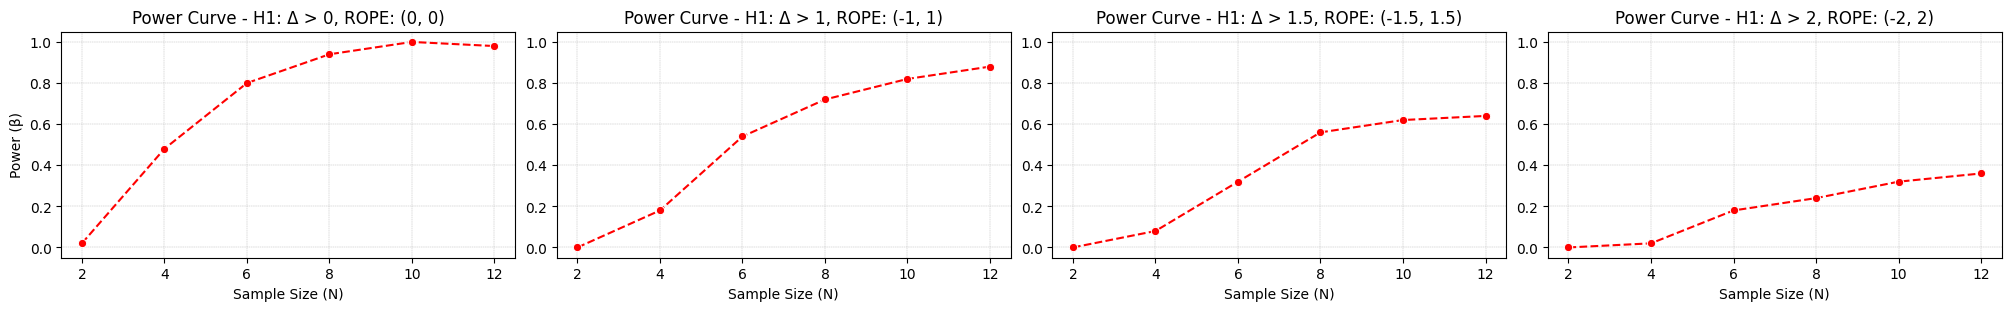

In [51]:
rope_space = [0, 1, 1.5, 2]

nrows, ncols = 1, len(rope_space)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True, sharex=True, sharey=True)

i = 0
for rope in rope_space:
    ax = axes[i // ncols, i % ncols]

    power = ((mu_delta_predicted > rope).mean(axis=(-1, -2, -3)) > .95).mean(axis=-1)

    sns.lineplot(x=N_space, y=power, marker="o", linestyle="--", color="r", ax=ax)

    ax.grid(linewidth=.3, linestyle="--", axis="both")
    ax.set_yticks(np.arange(0, 1.2, .2))
    ax.set_xticks(N_space)

    ax.set_title(f"Power Curve - H1: Δ > {rope}, ROPE: ({-1 * rope}, {rope})")
    ax.set_xlabel("Sample Size (N)")
    ax.set_ylabel("Power (β)")

    ax.yaxis.set_tick_params(labelleft=True)

    i += 1
